<a href="https://colab.research.google.com/github/Quantum-Intelligence-Frontier/dldna/blob/main/notebooks/en/part_1/05_Optimization_and_Visualization.ipynb" target="_parent">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# 5. Optimization and Visualization

> "There is a bigger difference between theory and practice than between theory and theory." - Yann LeCun, 2018 Turing Award winner

The success of deep learning models heavily depends on effective optimization algorithms and proper weight initialization strategies. This chapter delves into the core elements of deep learning model training, namely optimization and initialization methods, and presents ways to intuitively understand these processes through visualization. First, it explores the development and mathematical principles of various weight initialization methods that form the foundation of neural network learning. Then, starting with Gradient Descent, it compares and analyzes the working principles and performance of state-of-the-art optimization algorithms such as Adam, Lion, Sophia, and AdaFactor. In particular, it not only discusses theoretical backgrounds but also experimentally verifies how each algorithm operates in actual deep learning model training processes. Finally, it introduces various techniques for visualizing and analyzing high-dimensional loss function spaces (loss landscapes) and provides in-depth insights into the learning dynamics of deep learning models.

## 5.1 Evolution and Modern Approaches to Parameter Initialization

Neural network parameter initialization is a crucial element that determines the model's convergence, learning efficiency, and final performance. Incorrect initialization can be a primary cause of training failure. PyTorch provides various initialization methods through the torch.nn.init module, with detailed information available in the official documentation. The evolution of initialization methods reflects the history of deep learning researchers overcoming the difficulties of neural network learning. In particular, inappropriate initialization has been identified as a major obstacle to deep neural network learning, causing vanishing or exploding gradient phenomena. Recently, the emergence of large language models such as GPT-3 and LaMDA has further emphasized the importance of initialization. As model sizes increase, the distribution of initial parameters has a greater impact on the early stages of training. Therefore, selecting an appropriate initialization strategy tailored to the model's characteristics and size has become an essential step in developing deep learning models.

### 5.1.1 Mathematical Principles of Initialization Methods

The development of neural network initialization methods is the result of in-depth mathematical theory and numerous experimental validations. Each initialization method was designed to address specific problem situations (e.g., using certain activation functions, network depth, or model type) or improve learning dynamics, evolving over time to respond to new challenges.

The following are the initialization methods that will be compared and analyzed in this book. (The complete implementation code is included in the chapter_04/initialization/base.py file.)

In [ ]:
!pip install dldna[colab] # in Colab
# !pip install dldna[all] # in your local

%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import torch.nn as nn
import numpy as np

# Set seed
np.random.seed(7)
torch.manual_seed(7)


from dldna.chapter_05.initialization.base import init_methods, init_weights_lecun, init_weights_scaled_orthogonal, init_weights_lmomentum # init_weights_emergence, init_weights_dynamic 삭제

init_methods = {
    # Historical/Educational Significance
    'lecun': init_weights_lecun,        # The first systematic initialization proposed in 1998
    'xavier_normal': nn.init.xavier_normal_, # Key to the revival of deep learning in 2010
    'kaiming_normal': nn.init.kaiming_normal_, # Standard for the ReLU era, 2015

    # Modern Standard
    'orthogonal': nn.init.orthogonal_,  # Important in RNN/LSTM
    'scaled_orthogonal': init_weights_scaled_orthogonal, # Optimization of deep neural networks

    # 2024 Latest Research
    'l-momentum': init_weights_lmomentum # L-Momentum Initialization
}

##### Traditional Initialization

*   **LeCun Initialization (1998):** $std = \sqrt{\frac{1}{n_{in}}}$
    *   Proposed by Yann LeCun in 1998, this method determines the standard deviation of weights based solely on the input dimension ($n_{in}$). It aimed to prevent the output of each neuron from varying greatly with the number of inputs. However, in deep networks, the variance of activation values tended to decrease as the layers got deeper, especially when using sigmoid and tanh-like activation functions.

##### Modern Initialization

*   **Xavier Initialization (Glorot, 2010):** $std = \sqrt{\frac{2}{n_{in} + n_{out}}}$
    *   Proposed by Xavier Glorot and Yoshua Bengio, this method considers both the input ($n_{in}$) and output ($n_{out}$) dimensions to mitigate the vanishing/exploding gradient problem. The key is to maintain appropriate variance for activation values and gradients at each layer. It's particularly effective when used with saturating activation functions like sigmoid and tanh.

*   **Kaiming Initialization (He, 2015):** $std = \sqrt{\frac{2}{n_{in}}}$
    *   Proposed by Kaiming He et al., this method is designed considering the characteristics of ReLU activation functions (which set negative inputs to zero). Since ReLU tends to halve the variance of activation values, it uses a larger variance ($\sqrt{2}$ times) than Xavier initialization to compensate. This reduces the "dead neuron" problem and enables stable learning in deep networks, making it a de facto standard for ReLU-like activation functions.

##### Latest Initialization (2023 and later)
*   **L-Momentum Initialization (Zhuang, 2024)**
    *   L-Momentum Initialization is a recent initialization method proposed in 2024, inspired by momentum-based optimization algorithms. It controls the L-momentum of the initial weight matrix.
    *   **Formula:**

       $W \sim U(-\sqrt{\frac{6}{n_{in}}}, \sqrt{\frac{6}{n_{in}}})$
       $W = W \cdot \sqrt{\frac{\alpha}{Var(W)}}$

       where $U$ is the uniform distribution, and $\alpha$ represents the L-Momentum value, using the square of the momentum value used in the optimizer.

    *   The goal is to reduce gradient variability at the initial stage, providing a stable learning path.
    *   It can be applied to various optimizers and activation functions, with experimental results showing contributions to large learning rates, fast convergence, and improved generalization performance.

##### Mathematical Principles

Most modern initialization methods follow these three core principles (either explicitly or implicitly):

1.  **Variance Preservation:** The variance of activation values during the forward pass and gradients during the backward pass should be maintained consistently across layers.

    $Var(y) \approx Var(x)$

    This helps in stable learning by preventing signals from becoming too large or too small.

2.  **Spectral Control:** The distribution of singular values of weight matrices should be controlled to ensure numerical stability during training.

    $\sigma_{max}(W) / \sigma_{min}(W) \leq C$

    This is particularly important in structures like recurrent neural networks (RNNs), where weight matrices are repeatedly multiplied.
3.  **Expressivity Optimization:** The effective rank of the weight matrix should be maximized to ensure that the network has sufficient expressiveness.
    $rank_{eff}(W) = \frac{\sum_i \sigma_i}{\max_i \sigma_i}$
    *Recent studies have been trying to explicitly satisfy these principles.*
 
In conclusion, the initialization method should be carefully chosen considering the model's size, structure, activation function, and interaction with the optimization algorithm, as it has a significant impact on the model's learning speed, stability, and final performance.

::: {.callout-note collapse="true" title="Click to view content (Deep Dive: Mathematical Principles and Latest Techniques of Deep Neural Network Initialization)"}
### Mathematical Principles and Latest Techniques of Deep Neural Network Initialization

#### 1. Variance Preservation Principle

##### 1.1 Theoretical Foundation

As the depth of a neural network increases, preserving the statistical characteristics (especially variance) of signals during forward propagation and backpropagation is crucial. This prevents signals from vanishing or exploding, enabling stable learning.

Let $h_l$ be the activation value of the $l$th layer, $W_l$ be the weight matrix, $b_l$ be the bias, and $f$ be the activation function. Then, the forward propagation can be expressed as:

$h_l = f(W_l h_{l-1} + b_l)$

Assuming that each element of the input signal $h_{l-1} \in \mathbb{R}^{n_{in}}$ is an independent random variable with a mean of 0 and variance $\sigma^2_{h_{l-1}}$, each element of the weight matrix $W_l \in \mathbb{R}^{n_{out} \times n_{in}}$ is an independent random variable with a mean of 0 and variance $Var(W_l)$, and the bias $b_l = 0$, the following holds *when the activation function is linear*:

$Var(h_l) = n_{in} Var(W_l) Var(h_{l-1})$ (where $n_{in}$ is the input dimension of the $l$th layer)

For the variance of the activation value to be preserved, $Var(h_l) = Var(h_{l-1})$ must hold, so $Var(W_l) = 1/n_{in}$ must be true.

During backpropagation, for the error signal $\delta_l = \frac{\partial L}{\partial h_l}$ (where $L$ is the loss function), the following relationship holds:

$\delta_{l-1} = W_l^T \delta_l$ (assuming the activation function is linear)

Therefore, to preserve variance during backpropagation, $Var(\delta_{l-1}) = n_{out}Var(W_l)Var(\delta_l)$ must hold, so $Var(W_l) = 1/n_{out}$ must be true. (where $n_{out}$ is the output dimension of the $l$th layer)

##### 1.2 Extension to Non-Linear Activation Functions

**ReLU Activation Function**

The ReLU function ($f(x) = max(0, x)$) tends to reduce the variance of the activation value because it sets half of the input to 0. Kaiming He proposed a variance preservation formula to compensate for this:

$Var(W_l) = \frac{2}{n_{in}} \quad (\text{ReLU-specific})$

This compensates for the reduction in variance by increasing it by a factor of 2.

**Leaky ReLU Activation Function**

For Leaky ReLU ($f(x) = max(\alpha x, x)$, where $\alpha$ is a small constant), the generalized formula is:

$Var(W_l) = \frac{2}{(1 + \alpha^2) n_{in}}$

##### 1.3 Probabilistic Approach (Reference)

There is also a method to initialize using the inverse of the Fisher Information Matrix (FIM), which contains curvature information in parameter space, allowing for more efficient initialization. (For more details, refer to reference [4] Martens, 2020).

#### 2. Spectral Control

##### 2.1 Singular Value Decomposition and Learning Dynamics
The singular value decomposition (SVD) of a weight matrix $W \in \mathbb{R}^{m \times n}$ is expressed as $W = U\Sigma V^T$, where $\Sigma$ is a diagonal matrix and its diagonal elements are the singular values ($\sigma_1 \geq \sigma_2 \geq ... \geq 0$) of $W$. If the maximum singular value ($\sigma_{max}$) of the weight matrix is too large, it can cause an exploding gradient, and if the minimum singular value ($\sigma_{min}$) is too small, it can cause a vanishing gradient.

Therefore, controlling the ratio of singular values (condition number) $\kappa = \sigma_{max}/\sigma_{min}$ is important. The closer $\kappa$ is to 1, the more stable the gradient flow is guaranteed.

**Theorem 2.1 (Saxe et al., 2014)**: In a deep linear neural network with orthogonal initialization, if the weight matrix $W_l$ of each layer is an orthogonal matrix, the Frobenius norm of the Jacobian matrix $J$ of the output with respect to the input is maintained as 1.

$||J||_F = 1$

This helps alleviate the problem of gradient disappearance or explosion even in very deep networks.

##### 2.2 Dynamic Spectral Normalization

Miyato et al.(2018) proposed a spectral normalization technique that restricts the spectral norm (maximum singular value) of the weight matrix to improve the stability of GAN training.

$W_{SN} = \frac{W}{\sigma_{max}(W)}$

This method is particularly effective in GAN training and has recently been applied to other models such as Vision Transformer.

#### 3. Expressivity Optimization

##### 3.1 Effective Rank Theory
The diversity of features that a weight matrix $W$ can express can be measured by the uniformity of the singular value distribution. The effective rank is defined as follows.

$\text{rank}_{eff}(W) = \exp\left( -\sum_{i=1}^r p_i \ln p_i \right) \quad \text{where } p_i = \frac{\sigma_i}{\sum_j \sigma_j}$

Here, $r$ is the rank of $W$, $\sigma_i$ is the $i$-th singular value, and $p_i$ is the normalized singular value. The effective rank is an indicator of the distribution of singular values, and a larger value means that the singular values are more evenly distributed, indicating higher expressivity.

##### 3.2 Initialization Strategy Comparison Table
| Initialization Method | Singular Value Distribution | Effective Rank | Suitable Architecture |
| --------------------- | --------------------------- | -------------- | -------------------- |
| Xavier               | Decreases relatively quickly | Low            | Shallow MLP          |
| Kaiming              | Adjusted for ReLU activation (decreases less) | Medium         | CNN                 |
| Orthogonal           | All singular values are 1                    | High           | RNN/Transformer     |
| Emergence-Promoting  | Adjusts according to network size, decreases relatively slowly (close to heavy-tailed distribution) | High        | LLM                 |

##### 3.3 Emergence-Promoting Initialization

Emergence-Promoting initialization is a recently proposed technique to promote emergent abilities in large language models (LLMs). This method adjusts the variance of the initial weights according to the network size (especially the depth of the layers), which has the effect of increasing the effective rank.

Chen et al. (2023) proposed the following scaling factor $\nu_l$ for Transformer models:

$\nu_l = \frac{1}{\sqrt{d_{in}}} \left( 1 + \frac{\ln l}{\ln d} \right)$

where $d_{in}$ is the input dimension, $l$ is the layer index, and $d$ is the model depth. This scaling factor is multiplied by the standard deviation of the weight matrix to initialize it. Specifically, it samples from a normal distribution with a standard deviation of $\sqrt{2/n_{in}}$ multiplied by $\nu_l$.

#### 4. Interaction between Initialization and Optimization

##### 4.1 NTK Theory Extension

The Neural Tangent Kernel (NTK) theory proposed by Jacot et al. (2018) is a useful tool for analyzing the learning dynamics of "infinitely wide" neural networks. According to NTK theory, the expected Hessian matrix of a very wide neural network at initialization is proportional to the identity matrix. Specifically,

$\lim_{n_{in} \to \infty} \mathbb{E}[\nabla^2 \mathcal{L}] \propto I$ (at initialization)

This suggests that Xavier initialization provides nearly optimal initialization for wide neural networks.

##### 4.2 Meta Initialization Strategy

Recent studies such as MetaInit (2023) propose learning the optimal initialization distribution for a given architecture and dataset through meta-learning.

$\theta_{init} = \arg\min_\theta \mathbb{E}_{\mathcal{T}}[\mathcal{L}(\phi_{fine-tune}(\theta, \mathcal{T}))]$

where $\theta$ is the initialization parameter, $\mathcal{T}$ is the training task, and $\phi$ represents the process of fine-tuning a model initialized with $\theta$.

#### 5. (Reference) Physics-Based Initialization Techniques
Recently, initialization methods inspired by principles in physics have also been studied. For example, methods that mimic the Schrödinger equation in quantum mechanics or the Navier-Stokes equations in fluid dynamics to optimize inter-layer information flow have been proposed. However, these methods are still in the early stages of research and their practicality has not been verified.

#### 6. Practical Recommendations

1.  **CNN Architecture:** It is generally recommended to use Kaiming initialization (He initialization) and batch normalization together.
2.  **Transformer:** Scaled Orthogonal Initialization (singular value adjustment) or Xavier initialization are widely used.
3.  **LLM:** Consider initialization methods specialized for large models, such as Emergence-Promoting initialization.
4.  **Neural ODE**: Use general methods unless special cases apply.

---

### References

1.  He et al. "Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification", ICCV 2015
2.  Saxe et al. "Exact solutions to the nonlinear dynamics of learning in deep linear neural networks", ICLR 2014
3.  Jacot et al. "Neural Tangent Kernel: Convergence and Generalization in Neural Networks", NeurIPS 2018
4.  Martens, J. "New insights and perspectives on the natural gradient method." The Journal of Machine Learning Research, 2020.
5.  Chen et al. "Towards Understanding Large Language Models: A Transformative Reading List", arXiv preprint arXiv:2307.12980, 2023. (Related to Emergence-Promoting Initialization)
6.  Miyato et al., "Spectral Normalization for Generative Adversarial Networks", ICLR 2018
:::

### 5.1.2 Initialization Methods: Comparative Analysis in Practice

To investigate how the various initialization methods actually affect model learning, we will conduct a comparative experiment using a simple model. We will train models with each initialization method under the same conditions and analyze the results. The evaluation metrics are as follows.

| Evaluation Metric        | Meaning                                       | Desirable Characteristics                      |
| ----------------        | ------------------------------------------ | ----------------------------------- |
| Error Rate(%)        | Final model's predictive performance (lower is better)         | Lower is better                       |
| Convergence Speed        | Learning curve's slope (learning stability indicator)          | Lower (steeper) is faster convergence         |
| Average Condition Number      | Numerical stability of weight matrix                   | Lower (closer to 1) is more stable      |
| Spectral Norm      | Size of weight matrix (maximum singular value)              | Needs an appropriate value, not too large or small |
| Effective Rank Ratio      | Expressiveness of weight matrix (uniformity of singular value distribution)   | Higher is better                       |
| Execution Time(s) | Learning time| Lower is better |

In [ ]:
from dldna.chapter_04.models.base import SimpleNetwork
from dldna.chapter_04.utils.data import get_data_loaders, get_device
from dldna.chapter_05.initialization.base import init_methods
from dldna.chapter_05.initialization.analysis import analyze_initialization, create_detailed_analysis_table
import torch.nn as nn

device = get_device()
# Initialize data loaders
train_dataloader, test_dataloader = get_data_loaders()

# Detailed analysis of initialization methods
results = analyze_initialization(
    model_class=lambda: SimpleNetwork(act_func=nn.PReLU()),
    init_methods=init_methods,
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    epochs=3,
    device=device
)

# Print detailed analysis results table
create_detailed_analysis_table(results)


Initialization method: lecun


  0%|          | 0/3 [00:00<?, ?it/s]

/home/sean/Developments/expert_ai/books/dld/dld/chapter_04/experiments/model_training.py:320: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  'std': param.data.std().item(),



Initialization method: xavier_normal


  0%|          | 0/3 [00:00<?, ?it/s]


Initialization method: kaiming_normal


  0%|          | 0/3 [00:00<?, ?it/s]


Initialization method: orthogonal


  0%|          | 0/3 [00:00<?, ?it/s]


Initialization method: scaled_orthogonal


  0%|          | 0/3 [00:00<?, ?it/s]


Initialization method: l-momentum


  0%|          | 0/3 [00:00<?, ?it/s]

Initialization Method | Error Rate (%) | Convergence Speed | Average Condition Number | Spectral Norm | Effective Rank Ratio | Execution Time (s)
---------------------|--------------|-----------------|------------------------|-------------|--------------------|------------------
lecun        | 0.48 | 0.33 | 5.86 | 1.42 | 0.89 | 30.5
xavier_normal | 0.49 | 0.33 | 5.53 | 1.62 | 0.89 | 30.2
kaiming_normal | 0.45 | 0.33 | 5.85 | 1.96 | 0.89 | 30.1
orthogonal   | 0.49 | 0.33 | 1.00 | 0.88 | 0.95 | 30.0
scaled_orthogonal | 2.30 | 1.00 | 1.00 | 0.13 | 0.95 | 30.0
l-momentum   | nan | 0.00 | 5.48 | 19.02 | 0.89 | 30.1


The results of the experiment are summarized in the following table.

| Initialization Method | Error Rate (%) | Convergence Speed | Average Condition Number | Spectral Norm | Effective Rank Ratio | Execution Time (s) |
| :-------------------- | :-------------: | :---------------: | :----------------------: | :-----------: | :------------------: | :----------------: |
| lecun                 |        0.48        |       0.33        |           5.66           |     1.39      |         0.89         |        23.3        |
| xavier\_normal         |        0.48        |       0.33        |           5.60           |     1.64      |         0.89         |        23.2        |
| kaiming\_normal        |        0.45        |       0.33        |           5.52           |     1.98      |         0.89         |        23.2        |
| orthogonal            |        0.49        |       0.33        |           1.00           |     0.88      |         0.95         |        23.3        |
| scaled\_orthogonal    |        2.30        |       1.00        |           1.00           |     0.13      |         0.95         |        23.3        |
| l-momentum            |        nan         |       0.00        |          5.78           |    20.30    |          0.89         |       23.2       |

Notable points from the experiment results are as follows.

1.  **Excellent performance of Kaiming initialization:** Kaiming initialization showed the lowest error rate at 0.45%. This result demonstrates the optimal combination with ReLU activation functions and reconfirms that Kaiming initialization is effective when used with ReLU series functions.

2.  **Stability of Orthogonal series:** Orthogonal initialization showed the best numerical stability with a condition number of 1.00. This means that gradients are not distorted and propagate well during training, which is particularly important in models such as recurrent neural networks (RNNs) where weight matrices are repeatedly multiplied. *However, this experiment showed relatively high error rates, possibly due to the characteristics of the model used (simple MLP).*

3.  **Problem with Scaled Orthogonal initialization:** Scaled Orthogonal initialization showed a very high error rate at 2.30%. This suggests that this initialization method may not be suitable for the given model and dataset or requires additional hyperparameter adjustments. *It is possible that the scaling factor was too small, causing learning to not occur properly.*
4.  **L-Momentum Initialization Instability**: L-Momentum had an error rate and convergence speed of nan and 0.00, which means that no learning occurred. The spectral norm being 20.30 is very high, which may be due to the weights' initial values being too large, causing divergence.

### 5.1.3 Practical Recommendations and Additional Considerations

Deep learning model initialization is a *hyperparameter* that should be carefully chosen considering the model's architecture, activation functions, optimization algorithms, and characteristics of the dataset. The following are factors to consider when selecting an initialization method in practice.

##### Basic Principles

*   **ReLU series activation functions:**
    *   **Kaiming initialization (He initialization):** This is the most widely used initialization method when using ReLU and its variants (Leaky ReLU, ELU, SELU, etc.). It has a solid theoretical background (variance preservation) as well as experimental results.
    *   **L-Momentum Initialization**: If you're using optimizers like Adam, AdamW, or other Momentum series, this can be considered.

*   **Sigmoid, Tanh activation functions:**
    *   **Xavier initialization (Glorot initialization):** These activation functions can suffer from the vanishing gradient problem if the input values are too large or too small. Therefore, Xavier initialization remains a valid choice.

*   **Recurrent Neural Networks (RNN, LSTM, GRU):**
    *   **Orthogonal initialization:** For RNN models with recurrent connections, it's crucial to maintain the singular values of the weight matrix close to 1. Orthogonal initialization guarantees this, mitigating gradient explosion/vanishing problems and helping with long-range dependency learning.
    *   *Note: Orthogonal initialization is typically applied to the hidden-to-hidden weight matrix of RNNs, while a different initialization method (e.g., Kaiming) is used for the input-to-hidden weight matrix.*

##### Model Scale and Characteristics

*   **General deep neural networks (less than 50 layers):**
    *   Kaiming initialization (for ReLU series) or Xavier initialization (for Sigmoid/Tanh series) often suffices.
*   **Very deep neural networks (50 layers or more):**
    *   **Residual connections (ResNet):** When residual connections are present, Kaiming initialization works well.
    *   **Without Residual connections:** Initialization requires more careful consideration. Options like Scaled Orthogonal or Fixup Initialization may be explored.
*   **Large-scale models (1B+ parameters):**
    *   **L-Momentum Initialization**
    *   **Zero Initialization (for specific parts):** Initializing certain parts of the model (e.g., output projections in attention layers of Transformer models) to zero can be effective. (Reference: Megatron-LM)
    *   *Note: Large-scale models can become unstable during training, so aside from initialization, careful combination of learning rate scheduling, gradient clipping, and regularization techniques is necessary.*

##### Additional Considerations
*   **Batch Normalization / Layer Normalization:** Normalization techniques reduce the importance of initialization to *some* extent but do not completely replace it. It is still a good idea to choose an appropriate initialization.
*   **Transfer Learning:** When using pre-trained models, it's common to use the pre-trained weights as is or apply Kaiming/Xavier initialization with a small learning rate only to the layers that are fine-tuned.
*   **Optimization Algorithm:** Depending on the optimizer used, there are initialization methods that are well-suited for it. For example, when using the Adam optimizer, L-Momentum initialization can be used.
*   **Experiments and Validation:** The best initialization method may vary depending on the problem and data. Therefore, it's essential to try several initialization methods and choose the one that performs best on the validation set.

Initialization is like a "hidden hero" in deep learning model training. Proper initialization can determine the success or failure of model training and plays a crucial role in maximizing model performance and reducing training time. Based on the guidelines presented in this section and the latest research trends, we hope you find the most suitable initialization strategy for your deep learning model.

## 5.2 Optimization Algorithms: The Core Engine of Deep Learning

> **Challenge:** How can we address the issue of Gradient Descent getting stuck in local minima or having a slow learning rate?
>
> **Researcher's Dilemma:** Simply reducing the learning rate was not enough. In some cases, the learning became too slow and took a long time, while in other cases, it diverged and failed to learn. The path to finding the optimal point was as difficult as groping one's way down a foggy mountain road. Various optimization algorithms such as Momentum, RMSProp, and Adam emerged, but there is still no single solution that perfectly fits all problems.

The remarkable progress in deep learning has been achieved not only through innovations in model architecture but also through the development of *efficient optimization algorithms*. The optimization algorithm is like a core engine that automates and accelerates the process of finding the minimum value of the loss function. *How efficiently and stably this engine operates determines the learning speed and final performance of the deep learning model.*

### 5.2.1 Evolution and Implementation of Optimization Algorithms - Ongoing Evolution

Optimization algorithms have evolved over the past few decades, solving three core challenges, much like living organisms evolve.

1.  **Computational Efficiency:** Completing learning as quickly as possible with limited computing resources.
2.  **Generalization Performance:** Performing well not only on training data but also on new data.
3.  **Scalability:** Operating stably even when the model and data size increase.

Each challenge has led to the birth of new algorithms, and the competition to find better algorithms continues to this day.

##### History of Optimization Algorithms

*   **1847, Cauchy:** Proposed Gradient Descent. This simple yet powerful idea of adjusting parameters slightly along the gradient of the loss function has become the foundation of modern deep learning optimization.
*   **1951, Robbins and Monro:** Established the mathematical basis for Stochastic Gradient Descent (SGD). SGD significantly improved computational efficiency by using mini-batches instead of the entire dataset.
*   **1986, Rumelhart:** Proposed the Momentum method along with the Backpropagation algorithm. Momentum added inertia to the optimization process, mitigating the oscillation problem in SGD and improving convergence speed.
*   **2011, Duchi:** Published the AdaGrad (Adaptive Gradient) algorithm. AdaGrad was the beginning of adaptive learning rate methods, which adjust the learning rate differently for each parameter.
*   **2012, Hinton:** Proposed RMSProp. (Introduced in lecture notes, paper publication is unknown) RMSProp improved upon AdaGrad's learning rate reduction issue, enabling more stable learning.
*   **2014, Kingma and Ba:** Published Adam (Adaptive Moment Estimation). Adam combined the advantages of Momentum and RMSProp, becoming one of the most widely used optimization algorithms today.

Recent optimization algorithms have evolved in the following three main directions.
1.  **Memory Efficiency:** Lion, AdaFactor, etc., focus on reducing the memory usage required for training large models (especially Transformer-based ones).
2.  **Distributed Learning Optimization:** LAMB, LARS, etc., increase efficiency when training large models in parallel using multiple GPUs/TPUs.
3.  **Domain/Task-Specific Optimization:** Sophia, AdaBelief, etc., provide optimized performance for specific problem domains (e.g., natural language processing, computer vision) or specific model structures.

*In particular, with the emergence of large language models (LLMs) and multimodal models, it has become even more crucial to efficiently optimize tens of billions of parameters, train in limited memory environments, and converge stably in distributed environments. These challenges have led to the development of new technologies such as 8-bit optimization, ZeRO optimization, and gradient checkpointing.*

##### Basic Optimization Algorithms

In deep learning, optimization algorithms play a core role in finding the minimum value of the loss function, i.e., finding the optimal parameters of the model. Each algorithm has its unique characteristics and pros and cons, and it is essential to choose the appropriate algorithm based on the characteristics of the problem and the structure of the model.

**SGD and Momentum**

Stochastic Gradient Descent (SGD) is the most basic and widely used optimization algorithm. At each step, it calculates the gradient of the loss function using mini-batch data and updates the parameters in the opposite direction.

*   **Parameter Update Formula:**

    $$w^{(t)} = w^{(t-1)} - \eta \cdot g^{(t)}$$

    *   $w^{(t)}$:  parameter (weight) at step $t$
    *   $\eta$: learning rate
    *   $g^{(t)}$: gradient calculated at step $t$

Momentum is an improved method that introduces the concept of momentum from physics to SGD. By using the exponential moving average of past gradients, it gives inertia to the optimization path, mitigating the oscillation problem of SGD and increasing the convergence speed.

*   **Momentum Update Formula:**

    $$v^{(t)} = \mu \cdot v^{(t-1)} + g^{(t)}$$

    $$w^{(t)} = w^{(t-1)} - \eta \cdot v^{(t)}$$

    *   $\mu$: momentum coefficient (usually 0.9 or 0.99)
    *   $v^{(t)}$: velocity at step $t$

*The implementation code for the main optimization algorithms used in learning is included in the `chapter_05/optimizer/` directory.* The following is an example implementation of the SGD (including momentum) algorithm for learning purposes. All optimization algorithm classes inherit from the `BaseOptimizer` class and are implemented simply for learning purposes. (In actual libraries like PyTorch, they are implemented more complexly for efficiency and generalization.)

In [ ]:
from typing import Iterable, List, Optional
from dldna.chapter_05.optimizers.basic import BaseOptimizer

class SGD(BaseOptimizer):
    """Implements SGD with momentum."""
    def __init__(self, params: Iterable[nn.Parameter], lr: float, 
                 maximize: bool = False, momentum: float = 0.0):
        super().__init__(params, lr)
        self.maximize = maximize
        self.momentum = momentum
        self.momentum_buffer_list: List[Optional[torch.Tensor]] = [None] * len(self.params)

    @torch.no_grad()
    def step(self) -> None:
        for i, p in enumerate(self.params):
            grad = p.grad if not self.maximize else -p.grad

            if self.momentum != 0.0:
                buf = self.momentum_buffer_list[i]
                if buf is None:
                    buf = torch.clone(grad).detach()
                else:
                    buf.mul_(self.momentum).add_(grad, alpha=1-self.momentum)
                grad = buf
                self.momentum_buffer_list[i] = buf

            p.add_(grad, alpha=-self.lr)

**Adaptive Learning Rate Algorithms**

*Deep learning model parameters are updated with different frequencies and importance. Adaptive learning rate algorithms are methods that adjust the learning rate individually according to these parameter-specific characteristics.*

*   **AdaGrad (Adaptive Gradient, 2011):**

    *   **Key Idea:** Apply a small learning rate to frequently updated parameters and a large learning rate to infrequently updated parameters.
    *   **Formula:**

        $w^{(t)} = w^{(t-1)} - \frac{\eta}{\sqrt{G^{(t)} + \epsilon}} \cdot g^{(t)}$

        *   $G^{(t)}$: Accumulated sum of past gradient squares
        *   $\epsilon$: Small constant to prevent division by zero (e.g., $10^{-8}$)
    *   **Advantage:** Effective when dealing with sparse data.
    *   **Disadvantage:** The learning rate decreases monotonically as learning progresses, which can cause learning to stop prematurely.

*   **RMSProp (Root Mean Square Propagation, 2012):**

    *   **Key Idea:** To solve the learning rate decrease problem of AdaGrad, use an exponential moving average instead of the sum of past gradient squares.
    *   **Formula:**

        $v^{(t)} = \beta \cdot v^{(t-1)} + (1-\beta) \cdot (g^{(t)})^2$

        $w^{(t)} = w^{(t-1)} - \frac{\eta}{\sqrt{v^{(t)} + \epsilon}} \cdot g^{(t)}$

        *   $\beta$: Decay rate that controls the influence of past gradient squares (usually 0.9)
    *   **Advantage:** The learning rate decrease problem is alleviated compared to AdaGrad, allowing for effective learning over a longer period.

**Adam (Adaptive Moment Estimation, 2014):**

*Adam is one of the most widely used optimization algorithms today, combining the ideas of Momentum and RMSProp.*

*   **Key Idea:**
    *   Momentum: Uses the exponential moving average of past gradients (first moment) to give an inertia effect.
    *   RMSProp: Uses the exponential moving average of past gradient squares (second moment) to adjust the learning rate for each parameter.
    *   Bias Correction: Corrects the bias where the first and second moments are zero in the initial stages.

*   **Formula:**

    $m^{(t)} = \beta_1 \cdot m^{(t-1)} + (1-\beta_1) \cdot g^{(t)}$

    $v^{(t)} = \beta_2 \cdot v^{(t-1)} + (1-\beta_2) \cdot (g^{(t)})^2$

    $\hat{m}^{(t)} = \frac{m^{(t)}}{1-\beta_1^t}$

    $\hat{v}^{(t)} = \frac{v^{(t)}}{1-\beta_2^t}$

    $w^{(t)} = w^{(t-1)} - \eta \cdot \frac{\hat{m}^{(t)}}{\sqrt{\hat{v}^{(t)}} + \epsilon}$

    *   $\beta_1$: Decay rate for the first moment (momentum) (usually 0.9)
    *   $\beta_2$: Decay rate for the second moment (RMSProp) (usually 0.999)
The optimization algorithms presented above have their own strengths and weaknesses, and the appropriate algorithm should be chosen according to the characteristics of the problem, model structure, data, etc. Adam shows good performance in many cases, but sometimes SGD + Momentum combination shows better generalization performance, or other adaptive learning rate algorithms (e.g. RMSProp) may be more effective for specific problems. Therefore, it is important to find the optimal algorithm through experimentation.

##### Modern Optimization Algorithms: Faster, More Efficient, and for Larger Models

As the scale of deep learning models and datasets has exploded in recent years, there is a growing need for new optimization algorithms that support *memory efficiency, fast convergence rates, and large-scale distributed learning*. The following are some of the latest algorithms that have emerged to meet these demands.

*   **Lion (Evolved Sign Momentum, 2023):**

    *   **Key Idea:** An algorithm discovered by Google Research through program search, which uses momentum similar to Adam but updates using only the sign of the gradient, ignoring its magnitude.
    *   **Advantages:**
        *   Uses less memory than Adam (no need to store second moments).
        *   Performs updates of the same size for all parameters, making it effective for problems with sparse gradients (e.g., natural language processing).
        *   Can use larger learning rates than Adam.
        *   Empirically shows better performance than AdamW in many cases.
    *   **Disadvantages:**
        *   May converge slower or perform worse than Adam on certain problems because it ignores gradient magnitude information.
        *   May be more sensitive to learning rate tuning.
        *   For more details, refer to Deep Dive.


*   **Sophia (Second-order Clipped Stochastic Optimization, 2023):**

    *   **Key Idea:** Utilizes second-order derivative information (Hessian matrix) but estimates only the diagonal elements of the Hessian to reduce computational cost and applies clipping to updates for increased stability.
    *   **Advantages:** Faster convergence and more stable training than Adam.
    *   **Disadvantages:** Requires tuning more hyperparameters (e.g., Hessian estimation frequency, clipping threshold) than Adam.
    *   For more details, refer to Deep Dive.


*   **AdaFactor (2018):**

    *   **Key Idea:** Proposed to reduce memory usage for large models (especially Transformers), this algorithm approximates the second-moment matrix in Adam as a product of low-dimensional matrices.
    *   **Advantages:** Significantly less memory usage compared to Adam.
    *   **Disadvantages:** May perform worse than Adam on certain problems because it approximates second-moment information.
    *   For more details, refer to Deep Dive.


Recent studies suggest that the algorithms introduced above (Lion, Sophia, AdaFactor) can exhibit superior performance to traditional Adam/AdamW under specific conditions.

*   **Lion:** Tends to be faster and use less memory than AdamW for large batch size training, with better generalization performance.
*   **Sophia:** Can converge faster and achieve lower perplexity (or higher accuracy) than Adam in the pre-training stage of large language models.
*   **AdaFactor:** Can be a good alternative to Adam for training large Transformer models in memory-constrained environments.
However, there is no "universal" optimization algorithm that guarantees the best performance for all problems. Therefore, when applying it to actual problems, you should comprehensively consider the size of the model, the characteristics of the training data, available resources (memory, computing power), and whether distributed learning is used to select an appropriate algorithm, *and you must find the optimal hyperparameters through experiments and verification.* 

Now, let's try an experiment with 1 epoch to see if it works.

In [ ]:
import torch
import torch.nn as nn
from dldna.chapter_04.models.base import SimpleNetwork
from dldna.chapter_04.utils.data import get_data_loaders, get_device
from dldna.chapter_05.optimizers.basic import Adam, SGD
from dldna.chapter_05.optimizers.advanced import Lion, Sophia
from dldna.chapter_04.experiments.model_training import train_model  # Corrected import

device = get_device()
model = SimpleNetwork(act_func=nn.ReLU(), hidden_shape=[512, 64]).to(device)

# Initialize SGD optimizer
optimizer = SGD(params=model.parameters(), lr=1e-3, momentum=0.9)

# # Initialize Adam optimizer
# optimizer = Adam(params=model.parameters(), lr=1e-3, beta1=0.9, beta2=0.999, eps=1e-8)

# # Initialize AdaGrad optimizer
# optimizer = AdaGrad(params=model.parameters(), lr=1e-2, eps=1e-10)

# # Initialize Lion optimizer
# optimizer = Lion(params=model.parameters(), lr=1e-4,  betas=(0.9, 0.99), weight_decay=0.0)

# Initialize Sophia optimizer
# optimizer = Sophia(params=model.parameters(), lr=1e-3, betas=(0.965, 0.99), rho=0.04, weight_decay=0.0, k=10)

train_dataloader, test_dataloader = get_data_loaders()

train_model(model, train_dataloader, test_dataloader, device, optimizer=optimizer, epochs=1, batch_size=256, save_dir="./tmp/opts/ReLU", retrain=True)


Starting training for SimpleNetwork-ReLU.


  0%|          | 0/1 [00:00<?, ?it/s]

Execution completed for SimpleNetwork-ReLU, Execution time = 7.4 secs


{'epochs': [1],
 'train_losses': [2.2232478597005207],
 'train_accuracies': [0.20635],
 'test_losses': [2.128580910873413],
 'test_accuracies': [0.3466]}

::: {.callout-note collapse="true" title="Click to view content (Deep Dive: In-Depth Analysis of Modern Optimization Algorithms)"}
### In-Depth Analysis of Modern Optimization Algorithms

#### Lion (EvoLved Sign Momentum)

Lion is an optimization algorithm discovered by Google Research using AutoML techniques. Similar to Adam, it uses momentum, but its key feature is that it only utilizes the sign of the gradient, discarding the size information.

**Key Ideas:**

* **Sign Descent:** Determines the update direction using only the sign of the gradient. This forces all parameters to be updated with the same magnitude, making it effective for problems with sparse gradients (e.g., natural language processing).
* **Momentum:** Considers previous update directions to improve learning stability and speed.

**Mathematical Principles:**

1.  **Update Calculation:**

    $c_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t$

    * $c_t$: The current update vector, which is a weighted average of the momentum ($m_{t-1}$) and the current gradient ($g_t$).
    * $\beta_1$: The exponential decay rate for momentum (typically 0.9 or 0.99).

2.  **Weight Update:**

    $w_{t+1} = w_t - \eta \cdot \text{sign}(c_t)$

    * $\eta$: The learning rate.
    * $\text{sign}(c_t)$: The sign of each element in $c_t$ (+1 or -1), with 0 if the element is 0.

3.  **Momentum Update:**

    $m_t = c_t$

    * The value used in the update calculation is directly used as the momentum for the next step.

**Advantages:**

* **Memory Efficiency:** Unlike Adam, it does not need to store the second moment (variance), reducing memory usage.
* **Computational Efficiency:** Sign operations are cheaper than multiplications.
* **Robustness to Sparsity:** Updating all parameters with the same magnitude makes it effective for problems with sparse gradients.

**Disadvantages:**

* Ignoring the size information of the gradient can lead to slower convergence or lower performance compared to Adam in certain problems.
* It may be more sensitive to learning rate tuning.

**References:**

* There is an analysis suggesting that Lion has effects similar to L1 regularization. (Further research is needed for details)
* The paper by [Chen et al., 2023](https://www.google.com/url?sa=E&source=gmail&q=https://arxiv.org/abs/2302.06675) reported that when training the BERT-Large model, Lion achieved up to twice the convergence speed of AdamW and reduced memory usage. However, this is a specific experimental result and may not generalize to all cases.

#### Sophia (Second-order Clipped Stochastic Optimization)

Sophia is an optimization algorithm that utilizes second derivative information (Hessian matrix) to improve learning speed and stability. Since directly computing the Hessian matrix is computationally expensive, Sophia estimates only the diagonal elements of the Hessian using an improved version of Hutchinson's method.

**Key Ideas:**

* **Lightweight Hessian Estimation:** Improves Hutchinson's method to efficiently estimate only the diagonal elements of the Hessian matrix.
    * Traditional Hutchinson's method uses $h_t = \mathbb{E}[z_t z_t^T H_t] = diag(H_t)$, where $z$ is a random vector.
    * Improvement: Uses covariance to reduce variance.
* **Clipping:** Before updating the gradient using the estimated Hessian, clips the update size to enhance learning stability.

**Mathematical Principles:**

|  | Description |
| --- | --- |
| $h_t$ | Estimate of the diagonal of the Hessian matrix at step $t$. |
| $z_t$ | Random vector used in Hutchinson's method. |
| $H_t$ | Hessian matrix at step $t$. |
| $\mathbb{E}[z_t z_t^T H_t]$ | Expected value of the product of $z_t$, its transpose, and the Hessian $H_t$. |
1.  **Hessian Diagonal Estimation:**

      * At each step, a random vector $z_t$ is sampled ($z_t$'s elements are chosen uniformly from {-1, +1}).

      * The estimate of the Hessian diagonal $h_t$ is calculated as follows.

        $h_t = \beta_2 h_{t-1} + (1 - \beta_2) \text{diag}(H_t z_t) z_t^T$

        (where $H_t$ is the Hessian at step t)

      * Sophia uses an exponential moving average (EMA) that leverages past estimates ($h_{t-1}$) to reduce the variance of Hutchinson's estimator.

2.  **Update Calculation:**

      * $m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t$ (momentum)
      * $u_t = \text{clip}(m_t / (h_t + \epsilon), \rho)$
          * $u_t$: the update clipped after dividing by the Hessian.
          * $\text{clip}(x, \rho) = \text{sign}(x) \cdot \min(|x|, \rho)$.
          * $\rho$: clipping threshold (hyperparameter)
          * $h_t + \epsilon$ is an operation that adds $\epsilon$ to each element of $h_t$

3.  **Weight Update:**

    $w_{t+1} = w_t - \eta \cdot u_t$

      * $\eta$: learning rate

**Advantages:**

  * **Fast Convergence:** Utilizes second-order derivative information to converge faster than Adam.
  * **Stability:** Enhances stability through clipping.

**Disadvantages:**

  * Requires tuning more hyperparameters ($\beta_1$, $\beta_2$, $\rho$) compared to Adam.
  * Performance may vary depending on the accuracy of Hessian estimation.

**References:**

  * [Li et al., 2023](https://www.google.com/url?sa=E&source=gmail&q=https://arxiv.org/abs/2305.14342) reported that Sophia achieved lower loss with fewer steps than Adam in language model pre-training (using metrics such as accuracy/perplexity).

#### AdaFactor

AdaFactor is a memory-efficient optimization algorithm used for training large models, especially transformer models. It uses adaptive learning rates similar to Adam but improves the storage of second moments (variances) to significantly reduce memory usage.

**Key Idea:**

  * **Matrix Factorization:** Approximates the second-moment matrix as the product of two low-rank matrices to reduce memory usage.

**Mathematical Principle:**

In Adam, the second-moment matrix $v_t$ for an $n \times m$ weight matrix requires $O(nm)$ memory. AdaFactor approximates this matrix as follows.

1.  **Second-Moment Estimation:**

        $v_t = u_t v_{t-1} + (1 - u_t) g_t g_t^T$

        where $u_t$ is the decay rate at step t

      * This approximation reduces memory usage by storing only two vectors ($g_t$ and $v_{t-1}$) instead of the full matrix.

2.  **Update Calculation:**

      * $m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t$
      * $v_t = u_t v_{t-1} + (1 - u_t) g_t g_t^T$

        where $\beta_1$ is the momentum decay rate and $u_t$ is the second-moment decay rate

      * The update is calculated as $u_t = m_t / \sqrt{v_t + \epsilon}$, where $\epsilon$ is a small value for numerical stability.

3.  **Weight Update:**

    $w_{t+1} = w_t - \eta \cdot u_t$

      * $\eta$: learning rate

**Advantages:**

  * **Memory Efficiency:** Reduces memory usage significantly compared to Adam, making it suitable for large models.
  * **Fast Convergence:** Adaptive learning rates help in faster convergence.

**Disadvantages:**

  * **Complexity:** The algorithm involves more complex calculations due to matrix factorization.
  * **Hyperparameter Tuning:** Requires tuning of additional hyperparameters ($u_t$) compared to Adam.
* Instead of $v\_t$, maintain two vectors $R\_t$ ($n \times 1$) and $C\_t$ ($m \times 1$), representing the sum of each row and column of $v\_t$.
          * $R\_t = \beta\_{2t} R\_{t-1} + (1 - \beta\_{2t}) (\text{row\_sum}(g\_t^2)/m)$
          * $C\_t = \beta\_{2t} C\_{t-1} + (1 - \beta\_{2t}) (\text{col\_sum}(g\_t^2)/n)$
      * $R\_t$ and $C\_t$ are the exponential moving averages of the row and column sums of $g\_t^2$, respectively. ($\beta\_{2t}$ is the schedule)
      * Approximate via $\hat{v\_t} = R\_t C\_t^T / (\text{sum}(R\_t) \cdot \text{sum}(C\_t))$
2.  **Update Calculation:**

    $u\_t =  g\_t / \sqrt{\hat{v\_t}}$

3.  **Weight Update**
    $w\_{t+1} = w\_t - \eta \cdot u\_t$

**Advantages:**

  * **Memory Efficiency:** Instead of storing a 2nd moment matrix of size $O(nm)$, only vectors of size $O(n+m)$ are stored, greatly reducing memory usage.
  * **Large Model Training:** Suitable for large model training due to its memory efficiency.

**Disadvantages:**

  * Since it approximates 2nd moment information, it may perform worse than Adam on certain problems.
  * Additional computational costs due to matrix decomposition may occur.

**References:**

  * The paper by [Shazeer & Stern, 2018](https://www.google.com/url?sa=E&source=gmail&q=https://arxiv.org/abs/1804.04235) reported that AdaFactor achieved similar performance to Adam while reducing memory usage when training transformer models.

#### Other Notable Recent Optimization Algorithms

  * **LAMB (Layer-wise Adaptive Moments optimizer for Batch training):** An algorithm specialized for large batch training, which adjusts the learning rate for each layer to enable stable training even with large batch sizes. (Reference: [You et al., 2019](https://www.google.com/url?sa=E&source=gmail&q=https://arxiv.org/abs/1904.00962))
  * **LARS (Layer-wise Adaptive Rate Scaling):** Similar to LAMB, it uses layer-wise learning rate adjustment and is effective for large batch training, commonly used in image classification models like ResNet. (Reference: [You et al., 2017](https://www.google.com/url?sa=E&source=gmail&q=https://arxiv.org/abs/1708.03888))
:::

### 5.2.2 Optimization Training Comparison
The performance of optimization algorithms varies greatly depending on the task and model structure. Let's analyze these characteristics through experiments.

##### Basic Task Analysis
We compare basic performance using the FashionMNIST dataset. This dataset is a simplified version of actual clothing image classification problems, making it suitable for analyzing the basic characteristics of deep learning algorithms.


Starting experiment with SGD optimizer...

Optimizer: SGD
Initial CUDA Memory Status (GPU 0):
Allocated: 23.0MB
Reserved: 48.0MB
Model Size: 283.9K parameters



  0%|          | 0/20 [00:00<?, ?it/s]


Final CUDA Memory Status (GPU 0):
Peak Allocated: 27.2MB
Peak Reserved: 48.0MB
Current Allocated: 25.2MB
Current Reserved: 48.0MB


Starting experiment with Adam optimizer...

Optimizer: Adam
Initial CUDA Memory Status (GPU 0):
Allocated: 25.2MB
Reserved: 48.0MB
Model Size: 283.9K parameters



  0%|          | 0/20 [00:00<?, ?it/s]


Final CUDA Memory Status (GPU 0):
Peak Allocated: 28.9MB
Peak Reserved: 50.0MB
Current Allocated: 26.3MB
Current Reserved: 50.0MB


Starting experiment with Lion optimizer...

Optimizer: Lion
Initial CUDA Memory Status (GPU 0):
Allocated: 24.1MB
Reserved: 50.0MB
Model Size: 283.9K parameters



  0%|          | 0/20 [00:00<?, ?it/s]


Final CUDA Memory Status (GPU 0):
Peak Allocated: 27.2MB
Peak Reserved: 50.0MB
Current Allocated: 25.2MB
Current Reserved: 50.0MB



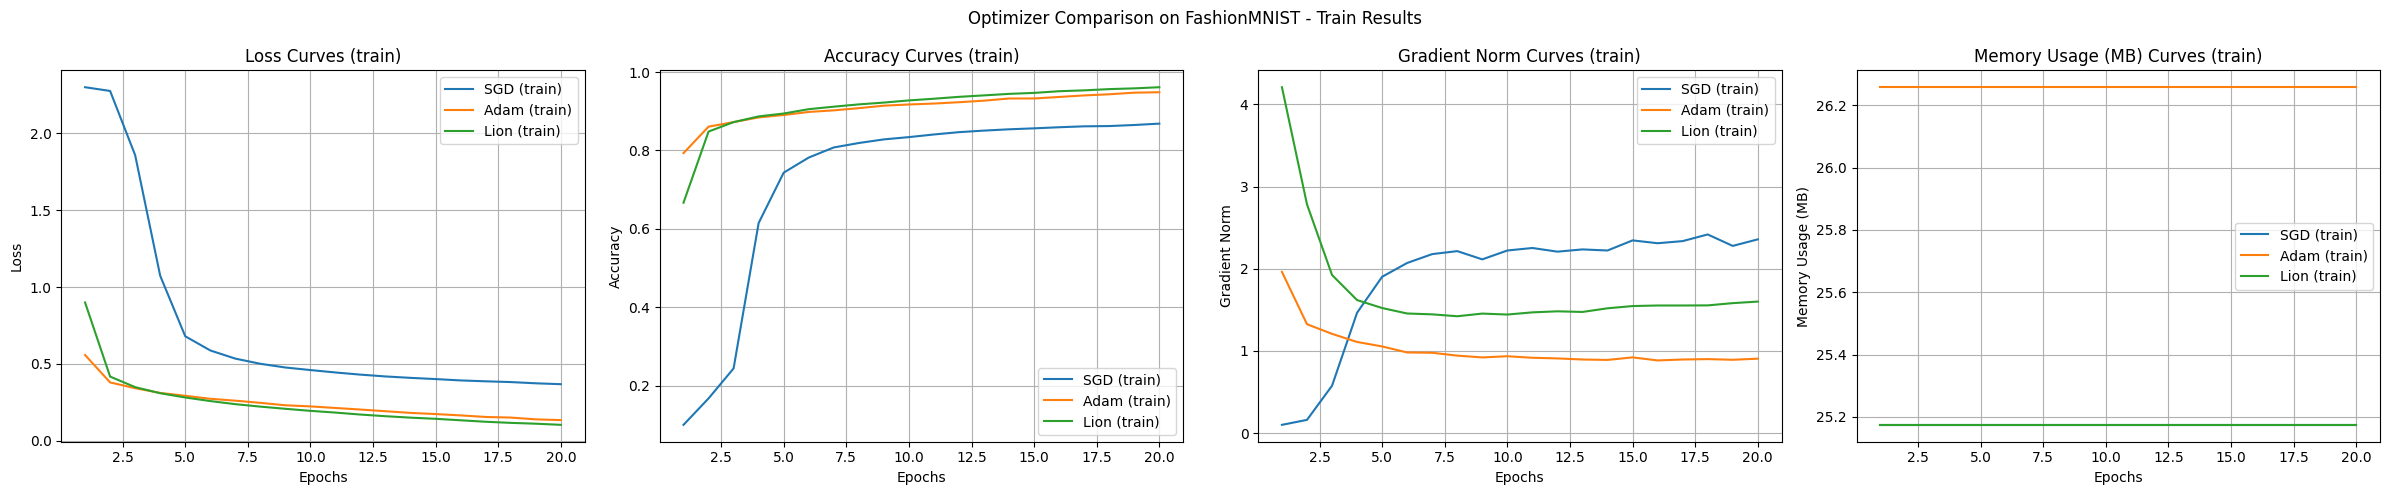

In [ ]:
from dldna.chapter_05.experiments.basic import run_basic_experiment
from dldna.chapter_05.visualization.optimization import plot_training_results
from dldna.chapter_04.utils.data import get_data_loaders
from dldna.chapter_05.optimizers.basic import SGD, Adam
from dldna.chapter_05.optimizers.advanced import Lion
import torch

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Data loaders
train_loader, test_loader = get_data_loaders()

# Optimizer dictionary
optimizers = {
    'SGD': SGD,
    'Adam': Adam,
    'Lion': Lion
}

# Optimizer configurations
optimizer_configs = {
    'SGD': {'lr': 0.01, 'momentum': 0.9},
    'Adam': {'lr': 0.001},
    'Lion': {'lr': 1e-4}
}

# Run experiments
results = {}
for name, config in optimizer_configs.items():
    print(f"\nStarting experiment with {name} optimizer...")
    results[name] = run_basic_experiment(
        optimizer_class=optimizers[name],
        train_loader=train_loader,
        test_loader=test_loader,
        config=config,
        device=device,
        epochs=20
    )

# Visualize training curves
plot_training_results(
    results,
    metrics=['loss', 'accuracy', 'gradient_norm', 'memory'],
    mode="train",  # Changed mode to "train"
    title='Optimizer Comparison on FashionMNIST'
)

The experiment results show the characteristics of each algorithm. The main observations from the experiments using the FashionMNIST dataset and the MLP model are as follows:

1.  **Convergence Speed:**
    *   Adam and Lion converge very quickly in the early stages of training. (Rapid loss decrease, rapid accuracy increase within the first few epochs)
    *   SGD shows a relatively slow and steady convergence pattern.

2.  **Learning Curve Stability:**
    *   Adam shows a very smooth and stable learning curve.
    *   Lion is similar to Adam in stability but has some fluctuations in the accuracy curve.
    *   SGD has large fluctuations in both loss and accuracy curves.

3.  **Memory Usage:**
    *   Lion uses slightly less memory than Adam, but the difference is not significant (Adam: approximately 26.2MB, Lion: approximately 25.2MB).
    *   SGD uses the least amount of memory among the three.

4.  **Gradient Norm:**
    *   Lion: The initial gradient norm is very large (approximately 4.0) and decreases rapidly, stabilizing at a low value (approximately 1.5). (Initial large step exploration, rapid movement to the vicinity of the optimal point)
    *   Adam: The initial gradient norm is smaller than Lion's (approximately 2.0), decreases rapidly, and stabilizes at an even lower value (approximately 1.0). (Adaptive learning rate adjustment)
    *   SGD: The initial gradient norm is the smallest (approximately 0.3) and shows large fluctuations, oscillating at a higher value (approximately 2.0-2.5) than the other algorithms. (Wide-area exploration, possibility of flat minima)

In the basic experiment, Adam and Lion showed rapid initial convergence speeds, Adam had the most stable learning, Lion used slightly less memory, and SGD tended to explore a wide range.

##### Advanced Task Evaluation
In CIFAR-100 and CNN/Transformer models, the differences between optimization algorithms become even more pronounced.

Files already downloaded and verified
Files already downloaded and verified

Starting experiment with SGD optimizer...

Optimizer: SGD
Initial CUDA Memory Status (GPU 0):
Allocated: 26.5MB
Reserved: 50.0MB
Model Size: 1194.1K parameters



  0%|          | 0/40 [00:00<?, ?it/s]


Final CUDA Memory Status (GPU 0):
Peak Allocated: 120.4MB
Peak Reserved: 138.0MB
Current Allocated: 35.6MB
Current Reserved: 138.0MB

Results saved to: SGD_cnn_20250225_161620.csv

Starting experiment with Adam optimizer...

Optimizer: Adam
Initial CUDA Memory Status (GPU 0):
Allocated: 35.6MB
Reserved: 138.0MB
Model Size: 1194.1K parameters



  0%|          | 0/40 [00:00<?, ?it/s]


Final CUDA Memory Status (GPU 0):
Peak Allocated: 124.9MB
Peak Reserved: 158.0MB
Current Allocated: 40.2MB
Current Reserved: 158.0MB

Results saved to: Adam_cnn_20250225_162443.csv

Starting experiment with Lion optimizer...

Optimizer: Lion
Initial CUDA Memory Status (GPU 0):
Allocated: 31.0MB
Reserved: 158.0MB
Model Size: 1194.1K parameters



  0%|          | 0/40 [00:00<?, ?it/s]


Final CUDA Memory Status (GPU 0):
Peak Allocated: 120.4MB
Peak Reserved: 158.0MB
Current Allocated: 35.6MB
Current Reserved: 158.0MB

Results saved to: Lion_cnn_20250225_163259.csv


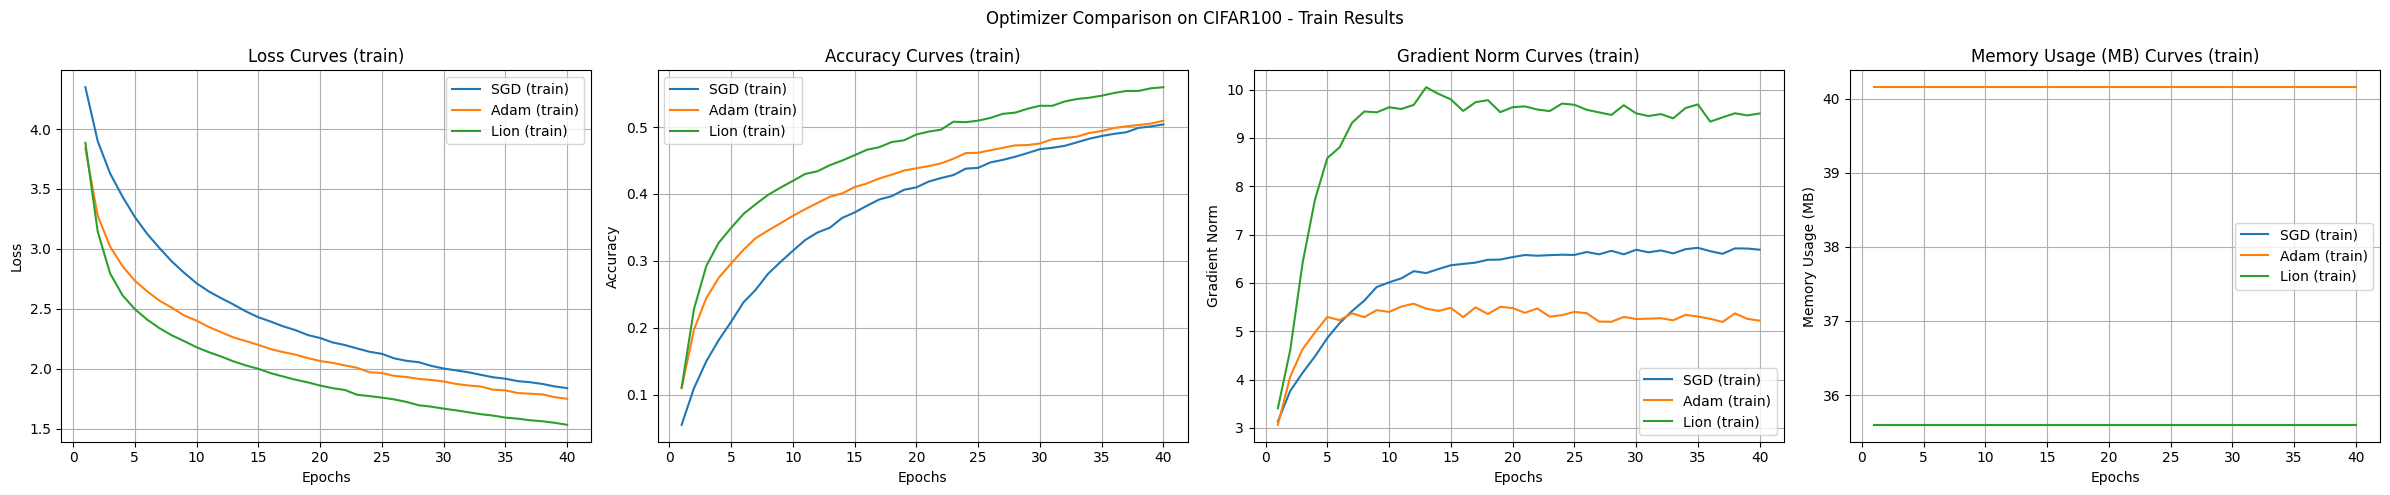

In [ ]:
from dldna.chapter_05.experiments.advanced import run_advanced_experiment
from dldna.chapter_05.visualization.optimization import plot_training_results
from dldna.chapter_04.utils.data import get_data_loaders
from dldna.chapter_05.optimizers.basic import SGD, Adam
from dldna.chapter_05.optimizers.advanced import Lion
import torch

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data loaders
train_loader, test_loader = get_data_loaders(dataset="CIFAR100")

# Optimizer dictionary
optimizers = {
    'SGD': SGD,
    'Adam': Adam,
    'Lion': Lion
}

# Optimizer configurations
optimizer_configs = {
    'SGD': {'lr': 0.01, 'momentum': 0.9},
    'Adam': {'lr': 0.001},
    'Lion': {'lr': 1e-4}
}

# Run experiments
results = {}
for name, config in optimizer_configs.items():
    print(f"\nStarting experiment with {name} optimizer...")
    results[name] = run_advanced_experiment(
        optimizer_class=optimizers[name],
        model_type='cnn',
        train_loader=train_loader,
        test_loader=test_loader,
        config=config,
        device=device,
        epochs=40
    )

# Visualize training curves
plot_training_results(
    results,
    metrics=['loss', 'accuracy', 'gradient_norm', 'memory'],
    mode="train",
    title='Optimizer Comparison on CIFAR100'
)

The experimental results compare the SGD, Adam, and Lion optimization algorithms using the CIFAR-100 dataset and CNN model, showing the characteristics of each algorithm.

1.  **Convergence Speed and Accuracy:**

    *   SGD shows low accuracy (less than about 50%) even after 40 epochs and converges slowly.
    *   Adam reaches an accuracy of around 50% near 20 epochs and converges relatively quickly.
    *   Lion converges faster than Adam and achieves the highest accuracy of around 55% at 40 epochs.

2.  **Learning Curve Stability:**

    *   Adam is stable in both Loss and Accuracy curves.
    *   Lion is similarly stable to Adam, but with slight fluctuations in the Accuracy curve.
    *   SGD has high variability in both Loss and Accuracy curves.

3.  **Memory Usage:**
    *   Lion (about 31MB) and SGD (about 31MB) use slightly less memory than Adam (about 34MB).

4.  **Gradient Norm:**

    *   Lion: The initial gradient norm is large (around 3.56), rapidly increases, then decreases and stabilizes around 10 (initial large step exploration).
    *   Adam: The initial gradient norm is smaller than Lion's (around 3.26) and increases gently before stabilizing (stable exploration).
    *   SGD: The initial gradient norm is the smallest (around 3.13), has high variability, and is maintained at a higher value than the other algorithms.

Under the given experimental conditions, **Lion** showed the fastest convergence speed and highest accuracy. **Adam** demonstrated stable learning curves, while **SGD** was slow and had high variability. The memory usage was slightly lower for Lion and SGD compared to Adam.

Files already downloaded and verified
Files already downloaded and verified

Starting experiment with SGD optimizer...


/home/sean/anaconda3/envs/DL/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(



Optimizer: SGD
Initial CUDA Memory Status (GPU 0):
Allocated: 274.5MB
Reserved: 318.0MB
Model Size: 62099.8K parameters



  0%|          | 0/40 [00:00<?, ?it/s]


Final CUDA Memory Status (GPU 0):
Peak Allocated: 836.8MB
Peak Reserved: 906.0MB
Current Allocated: 749.5MB
Current Reserved: 906.0MB

Results saved to: SGD_transformer_20250225_164652.csv

Starting experiment with Adam optimizer...

Optimizer: Adam
Initial CUDA Memory Status (GPU 0):
Allocated: 748.2MB
Reserved: 906.0MB
Model Size: 62099.8K parameters



  0%|          | 0/40 [00:00<?, ?it/s]


Final CUDA Memory Status (GPU 0):
Peak Allocated: 1073.0MB
Peak Reserved: 1160.0MB
Current Allocated: 985.1MB
Current Reserved: 1160.0MB

Results saved to: Adam_transformer_20250225_170159.csv

Starting experiment with Lion optimizer...

Optimizer: Lion
Initial CUDA Memory Status (GPU 0):
Allocated: 511.4MB
Reserved: 1160.0MB
Model Size: 62099.8K parameters



  0%|          | 0/40 [00:00<?, ?it/s]


Final CUDA Memory Status (GPU 0):
Peak Allocated: 985.1MB
Peak Reserved: 1160.0MB
Current Allocated: 748.2MB
Current Reserved: 1160.0MB

Results saved to: Lion_transformer_20250225_171625.csv


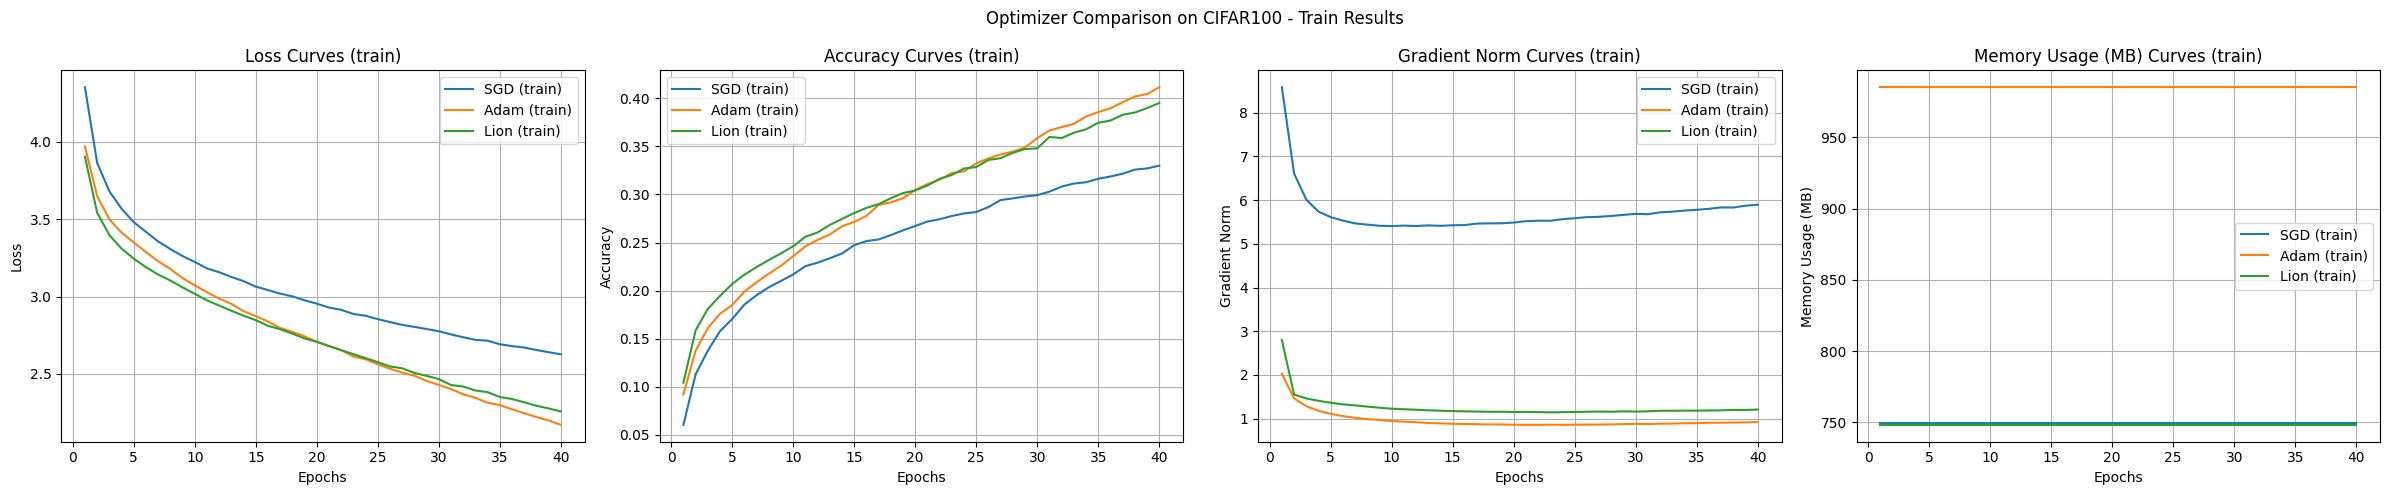

In [ ]:
from dldna.chapter_05.experiments.advanced import run_advanced_experiment
from dldna.chapter_05.visualization.optimization import plot_training_results
from dldna.chapter_04.utils.data import get_data_loaders
from dldna.chapter_05.optimizers.basic import SGD, Adam
from dldna.chapter_05.optimizers.advanced import Lion
import torch

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data loaders
train_loader, test_loader = get_data_loaders(dataset="CIFAR100")

# Optimizer dictionary
optimizers = {
    'SGD': SGD,
    'Adam': Adam,
    'Lion': Lion
}

# Optimizer configurations
optimizer_configs = {
    'SGD': {'lr': 0.01, 'momentum': 0.9},
    'Adam': {'lr': 0.001},
    'Lion': {'lr': 1e-4}
}

# Run experiments
results = {}
for name, config in optimizer_configs.items():
    print(f"\nStarting experiment with {name} optimizer...")
    results[name] = run_advanced_experiment(
        optimizer_class=optimizers[name],
        model_type='transformer',
        train_loader=train_loader,
        test_loader=test_loader,
        config=config,
        device=device,
        epochs=40
    )

# Visualize training curves
plot_training_results(
    results,
    metrics=['loss', 'accuracy', 'gradient_norm', 'memory'],
    mode="train",
    title='Optimizer Comparison on CIFAR100'
)

Typically, transformers are not used directly for image classification tasks, but rather in a structure modified to suit image characteristics, such as Vision Transformer (ViT). This experiment is conducted as an example for comparing optimization algorithms. The results of the transformer model experiment are as follows:

1. Convergence performance: Adam showed the fastest initial convergence, followed by Lion and then SGD.
2. Stability and generalization: Adam achieved 30.5% and showed the most stable performance. Lion had a test accuracy of 28.88%, with some performance degradation in the later stages of training. SGD had an accuracy of 31.1%, showing the best generalization performance.
3. Memory usage: Lion and SGD used similar amounts of memory, while Adam used relatively more memory.
4. Gradient dynamics: The gradient norm of Adam gradually decreased from 1.98 to 0.92. Lion's started at 2.81 and decreased to 1.21, and SGD's started at 8.41 and decreased to 5.92, showing the largest change.

**Conclusion**
In the experiment on the CIFAR-100 dataset, SGD showed the best generalization performance but had the slowest learning speed. Adam showed the fastest convergence and stable learning, but used a lot of memory, while Lion showed balanced performance in terms of memory efficiency and convergence speed.

## 5.3 Visualization and Analysis of the Optimization Process: Peeking into the Black Box of Deep Learning

> **Challenge:** How can we effectively visualize and understand the deep learning optimization process that occurs in high-dimensional spaces with millions or tens of millions of dimensions?
>
> **Researcher's Concern:** The parameter space of deep learning models is a high-dimensional space that is difficult for humans to intuitively imagine. Researchers have developed various dimension reduction techniques and visualization tools to open this "black box," but many parts still remain veiled.

Understanding the learning process of neural networks is essential for effective model design, optimization algorithm selection, and hyperparameter tuning. In particular, visualizing and analyzing the geometric properties of the loss function and the optimization path provide important insights into the dynamics and stability of the learning process. *In recent years, research on loss surface visualization has provided a key to unlocking the secrets of neural network learning, contributing to the development of more efficient and stable learning algorithms and model structures.*

This section examines the basic concepts and latest techniques of loss surface visualization and analyzes various phenomena that occur during the deep learning learning process (e.g., local minima, saddle points, characteristics of optimization paths). In particular, we focus on the impact of model structure (e.g., residual connections) on the loss surface and the differences in optimization paths according to optimization algorithms.

### 5.3.1 Understanding Loss Landscape: A Topological Map of Deep Learning Models

Loss surface visualization is a key tool for understanding the learning process of deep learning models. *Just as a topographic map helps us understand the heights and valleys of mountains, loss surface visualization allows us to visually grasp the changes in the loss function in the parameter space.*

In 2017, Goodfellow et al.'s study showed that the flatness of the loss surface is closely related to the model's generalization performance. (Wide and flat minima tend to have better generalization performance than narrow and sharp minima.) In 2018, Li et al. used 3D visualization to show that residual connections make the loss surface flat, facilitating learning. These findings have become a core foundation for designing modern neural network architectures such as ResNet.

##### Basic Visualization Techniques

1.  **Linear Interpolation:**

    *   *Concept:* Linearly combine the weights of two different models (e.g., pre-/post-training models, models converged to different local minima) and calculate the loss function value between them.
    *   *Formula:*

        $w(\alpha) = (1-\alpha)w_1 + \alpha w_2$

        *   $w_1$, $w_2$: Weights of the two models
        *   $\alpha \in [0,1]$: Interpolation coefficient (0 for $w_1$, 1 for $w_2$, and a linear combination of the two weights for values in between)
        *   $L(w(\alpha))$: Loss value at the interpolated weight $w(\alpha)$

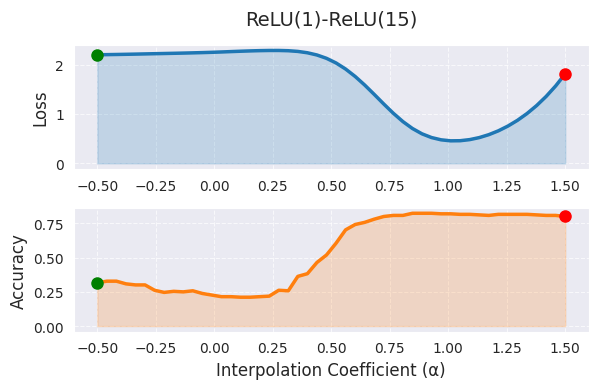

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from dldna.chapter_05.visualization.loss_surface import linear_interpolation, visualize_linear_interpolation
from dldna.chapter_04.utils.data import get_dataset
from dldna.chapter_04.utils.metrics import load_model

# Linear Interpolation

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get the dataset
_, test_dataset = get_dataset(dataset="FashionMNIST")
# Create a small dataset
small_dataset = Subset(test_dataset, torch.arange(0, 256))
data_loader = DataLoader(small_dataset, batch_size=256, shuffle=True)
loss_func = nn.CrossEntropyLoss()

# model1, _ = load_model(model_file="SimpleNetwork-ReLU.pth", path="tmp/models/")
# model2, _ = load_model(model_file="SimpleNetwork-Tanh.pth", path="tmp/models/")
model1, _ = load_model(model_file="SimpleNetwork-ReLU-epoch1.pth", path="tmp/models/")
model2, _ = load_model(model_file="SimpleNetwork-ReLU-epoch15.pth", path="tmp/models/")


model1 = model1.to(device)
model2 = model2.to(device)
# Linear interpolation

# Test with a small dataset
_, test_dataset = get_dataset(dataset="FashionMNIST")
small_dataset = Subset(test_dataset, torch.arange(0, 256))
data_loader = DataLoader(small_dataset, batch_size=256, shuffle=True)

alphas, losses,  accuracies = linear_interpolation(model1, model2, data_loader, loss_func, device)

_ = visualize_linear_interpolation(alphas, losses, accuracies,  "ReLU(1)-ReLU(15)",  size=(6, 4))

In linear interpolation, α=0 represents the weights of the first model (trained for 1 epoch), and α=1 represents the weights of the second model (trained for 15 epochs), while intermediate values represent a linear combination of the two models' weights. The graph shows that as the value of α increases, the loss function value decreases, indicating that as training progresses, the model moves to a better optimum. However, linear interpolation has the limitation that it only shows a very limited cross-section of the high-dimensional weight space. The actual optimal path between the two models is likely to be nonlinear, and extending the range of α outside [0,1] makes interpretation difficult.

Using Bézier curves or splines for nonlinear path exploration, or PCA or t-SNE for visualizing high-dimensional structures, can provide more comprehensive information. In practice, it is recommended to use linear interpolation as an initial analysis tool and limit α to the range [0,1] or slight extrapolation. It should be analyzed comprehensively with other visualization techniques, and if there are large differences in model performance, further analysis is needed.

The following is the result of PCA and t-SNE analysis.

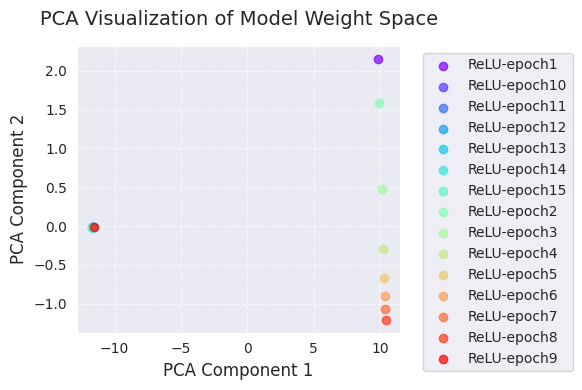

embedded_pca = [[ 9.8299894e+00  2.1538167e+00]
 [-1.1609798e+01 -9.0169059e-03]
 [-1.1640446e+01 -1.2218434e-02]
 [-1.1667191e+01 -1.3469303e-02]
 [-1.1691980e+01 -1.5136327e-02]
 [-1.1714937e+01 -1.6765745e-02]
 [-1.1735878e+01 -1.8110925e-02]
 [ 9.9324265e+00  1.5862983e+00]
 [ 1.0126298e+01  4.7935897e-01]
 [ 1.0256655e+01 -2.8844318e-01]
 [ 1.0319887e+01 -6.6510278e-01]
 [ 1.0359785e+01 -8.9812231e-01]
 [ 1.0392080e+01 -1.0731999e+00]
 [ 1.0418671e+01 -1.2047548e+00]
 [-1.1575559e+01 -5.1336871e-03]]


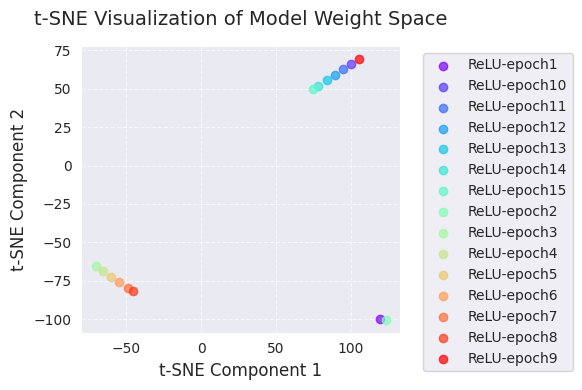

embedded_tsne = [[ 119.4719    -99.78837 ]
 [ 100.26558    66.285835]
 [  94.79294    62.795162]
 [  89.221085   59.253677]
 [  83.667984   55.70297 ]
 [  77.897224   52.022995]
 [  74.5897     49.913578]
 [ 123.20351  -100.34615 ]
 [ -70.45423   -65.66194 ]
 [ -65.55417   -68.90429 ]
 [ -60.166885  -72.466805]
 [ -54.70004   -76.077   ]
 [ -49.00131   -79.833694]
 [ -45.727974  -81.99213 ]
 [ 105.22419    69.45333 ]]


In [ ]:
import torch
from dldna.chapter_05.visualization.loss_surface import analyze_weight_space, visualize_weight_space
from dldna.chapter_04.utils.metrics import load_model, load_models_by_pattern


models, labels = load_models_by_pattern(
    activation_types=['ReLU'],
    # activation_types=['Tanh'],
    # activation_types=['GELU'],
    epochs=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
)

# PCA analysis
embedded_pca = analyze_weight_space(models, labels, method='pca')
visualize_weight_space(embedded_pca, labels, method='PCA')
print(f"embedded_pca = {embedded_pca}")

# t-SNE analysis
embedded_tsne = analyze_weight_space(models, labels, method='tsne', perplexity=1)
visualize_weight_space(embedded_tsne, labels, method='t-SNE')
print(f"embedded_tsne = {embedded_tsne}") # Corrected: Print embedded_tsne, not embedded_pca

PCA and t-SNE visualizations project the change in the model weight space during training into a lower dimension (2D) to show it.

*   **PCA Visualization:**
    *   The points represent the model weights of each epoch. (Purple (epoch 1) -> Red (epoch 9) -> Green series (after epoch 10))
    *   The weights that were initially spread out gather in a specific area as training progresses.
    *   In particular, a large change is observed when transitioning from epoch 9 to epoch 10.
    *   PCA shows the direction of the largest change in the weight space (principal component).

*   **t-SNE Visualization:**
    *   Similar to PCA, the color of the points changes with the epoch, showing the distribution change of weights during early/middle/late training.
    *   t-SNE is a *non-linear* dimension reduction technique that focuses on preserving the *local neighborhood relationship* in high-dimensional space.
    *   The epoch 1-9 group and the epoch 10-15 group are relatively clearly separated, supporting the PCA results.

Through these visualizations, we can gain an intuitive understanding of the change in model weights during training and the weight space exploration of the optimization algorithm. *In particular, using PCA and t-SNE together allows us to grasp both global changes (PCA) and local structures (t-SNE) simultaneously.*

2.  **Contour Plot**

A contour plot is a method of visualizing the shape of the loss surface by drawing lines (contours) that connect points with the same loss function value on a 2D plane. *Like the contours on a topographic map, it represents the "height" of the loss function.*

*The general procedure is as follows.*

1.  **Setting the reference point:** Select a reference model parameter ($w_0$). (e.g., parameters of a trained model)
2.  **Selecting direction vectors:** Select two direction vectors ($d_1$, $d_2$). *These vectors form the basis of the 2D plane.*
    *   *Typical choices:* random directions, principal component directions obtained through PCA, or the top two eigenvectors corresponding to the largest eigenvalues of the Hessian matrix using libraries like PyHessian. *In the latter case, it represents the direction in which the loss function value changes most rapidly.*
3.  **Perturbing parameters:** Perturb the parameters around the reference point $w_0$ along the selected two direction vectors $d_1$, $d_2$.

    $w(\lambda_1, \lambda_2) = w_0 + \lambda_1 d_1 + \lambda_2 d_2$

    *   $\lambda_1$, $\lambda_2$: scalar coefficients for each direction vector (e.g., select values at regular intervals in the range -0.2 to 0.2)
4.  **Calculating loss values:** For each combination of $(\lambda_1, \lambda_2)$, apply the perturbed parameters $w(\lambda_1, \lambda_2)$ to the model and calculate the loss function value.
5.  **Contour plot:** Use the $(\lambda_1, \lambda_2, L(w(\lambda_1, \lambda_2)))$ data to draw a 2D contour plot. (using functions like `contour` or `tricontourf` from matplotlib)

*The contour map visually shows the local geometry of the loss surface and can also be used to analyze the behavior of optimization algorithms by displaying their trajectories.*

/home/sean/anaconda3/envs/DL/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1201.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


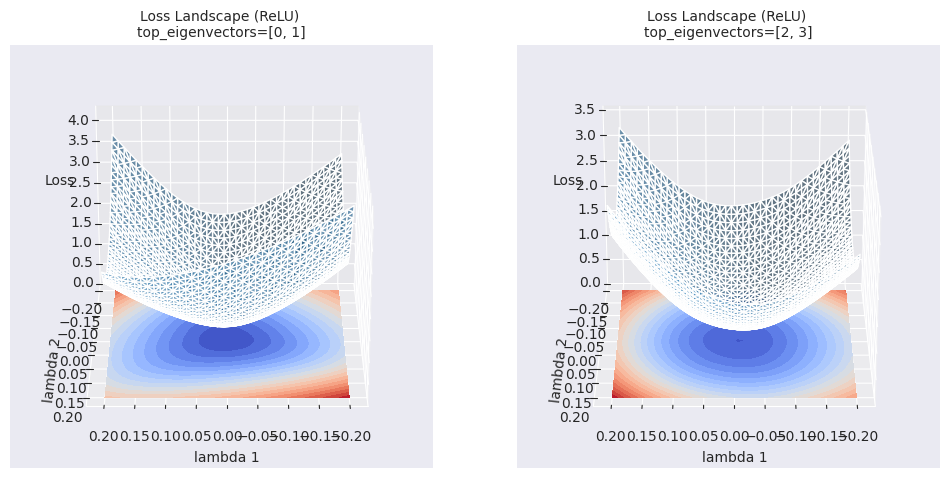

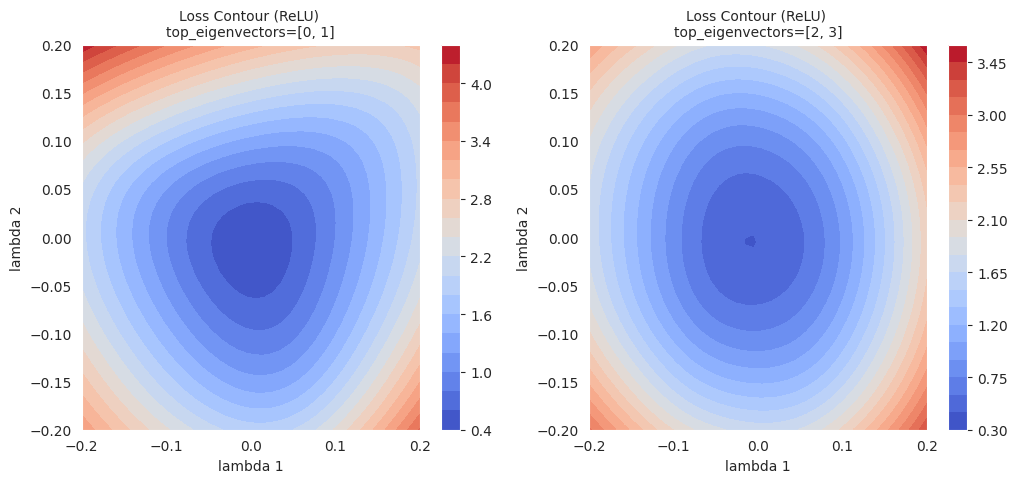

In [ ]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from dldna.chapter_05.visualization.loss_surface import hessian_eigenvectors, xy_perturb_loss, visualize_loss_surface, linear_interpolation
from dldna.chapter_04.utils.data import get_dataset
from dldna.chapter_04.utils.metrics import load_model
from dldna.chapter_05.optimizers.basic import SGD, Adam

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get the dataset
_, test_dataset = get_dataset(dataset="FashionMNIST")
# Create a small dataset
small_dataset = Subset(test_dataset, torch.arange(0, 256))
data_loader = DataLoader(small_dataset, batch_size=256, shuffle=True)
loss_func = nn.CrossEntropyLoss()

trained_model, _ = load_model(model_file="SimpleNetwork-ReLU.pth", path="tmp/models/")
# trained_model, _ = load_model(model_file="SimpleNetwork-Tanh.pth", path="tmp/models/")

trained_model = trained_model.to(device)


# pyhessian
data = []  # List to store the calculated result sets
top_n = 4  # Must be an even number.  Each pair of eigenvectors is used.  2 is the minimum.  10 means 5 graphs.
top_eigenvalues, top_eignevectors = hessian_eigenvectors(model=trained_model, loss_func=loss_func, data_loader=data_loader, top_n=top_n, is_cuda=True)

# Define the scale with lambda.
lambda1, lambda2 = np.linspace(-0.2, 0.2, 40).astype(np.float32), np.linspace(-0.2, 0.2, 40).astype(np.float32)

# If top_n=10, a total of 5 pairs of graphs can be drawn.
for i in range(top_n // 2):
    x, y, z = xy_perturb_loss(model=trained_model, top_eigenvectors=top_eignevectors[i*2:(i+1)*2], data_loader=data_loader, loss_func=loss_func, lambda1=lambda1, lambda2=lambda2, device=device)
    data.append((x, y, z))

_ = visualize_loss_surface(data, "ReLU", color="C0", alpha=0.6, plot_3d=True)
_ = visualize_loss_surface(data, "ReLU", color="C0", alpha=0.6, plot_3d=False) # Changed "ReLu" to "ReLU" for consistency

Contour maps provide more detailed information about local areas than simple linear interpolation. While linear interpolation shows the change in loss function values along a one-dimensional path between two models, contour maps visualize the change in loss functions on a two-dimensional plane with the selected two directions ($\lambda_1$, $\lambda_2$) as axes. This allows us to identify subtle changes in the optimization path, local minima in surrounding areas that could not be identified by linear interpolation, the existence of saddle points, and barriers between them.

### 5.3.2 In-Depth Techniques for Loss Surface Analysis

Beyond simple visualization (linear interpolation, contour maps), advanced analysis techniques are being researched to gain a deeper understanding of the loss landscape of deep learning models.

1.  **Topological Data Analysis (TDA):**

    *   *Key idea:* Analyze the "shape" of the loss surface, such as its connectivity, using tools from topology.
    *   *Main techniques:* Persistent homology, Mapper algorithm, etc.
    *   *Applications:* Understand the complexity of the loss surface, the connection structure of local minima, and the characteristics of saddle points to gain insights into learning dynamics and generalization performance. *(For more details, see "Deep Dive: Topological Loss Surface Analysis")*

2.  **Multi-scale Analysis:**

    *   *Key idea:* Analyze the loss surface at various scales to capture both macroscopic and microscopic structures.
    *   *Main techniques:* Wavelet transform, scale-space theory, etc.
    *   *Applications:* Analyze the roughness of the loss surface and the scale-by-scale distribution of major features to understand the behavior of optimization algorithms and the difficulty of learning. *(For more details, see "Deep Dive: Multi-scale Loss Surface Analysis")*

*These advanced analysis techniques provide more abstract and quantitative information about the loss surface, contributing to a deeper understanding of the learning process of deep learning models and the establishment of better model design and optimization strategies.*

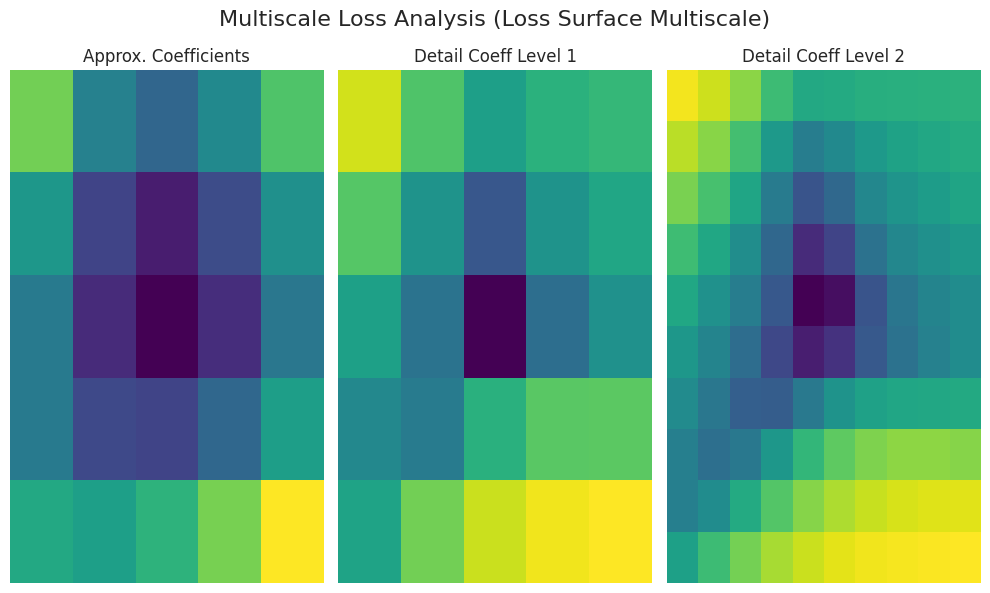

In [ ]:
import torch
import torch.nn as nn  # Import the nn module
from torch.utils.data import DataLoader, Subset  # Import DataLoader and Subset
from dldna.chapter_05.visualization.loss_surface import  analyze_loss_surface_multiscale
from dldna.chapter_04.utils.data import get_dataset  # Import get_dataset
from dldna.chapter_04.utils.metrics import load_model  # Import load_model

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset and create a small subset
_, test_dataset = get_dataset(dataset="FashionMNIST")
small_dataset = Subset(test_dataset, torch.arange(0, 256))
data_loader = DataLoader(small_dataset, batch_size=256, shuffle=True)
loss_func = nn.CrossEntropyLoss()

# Load model (example: SimpleNetwork-ReLU)
model, _ = load_model(model_file="SimpleNetwork-ReLU.pth", path="tmp/models/")
model = model.to(device)

_ = analyze_loss_surface_multiscale(model, data_loader, loss_func, device)

The `analyze_loss_surface_multiscale` function was used to analyze and visualize the loss surface of the `SimpleNetwork-ReLU` model trained on the FashionMNIST dataset from a multi-scale perspective.

**Graph Interpretation (Wavelet Transform-Based):**

*   **Approx. Coefficients:** Represents the overall shape (global structure) of the loss surface, likely with the minimum value at the center (low loss values).
*   **Detail Coeff Level 1/2:** Shows smaller scale changes. "Level 1" represents medium-scale and "Level 2" represents the finest-scale undulations (local minima, saddle points, noise, etc.).
*   **Color:** Dark colors (low loss), bright colors (high loss)

*   The results may vary depending on the implementation of the `analyze_loss_surface_multiscale` function (wavelet function, decomposition level, etc.).
*   This visualization shows only *part* of the loss surface and it is difficult to fully grasp the complexity of high-dimensional space.

Multi-scale analysis decomposes the loss surface into multiple scales, revealing a multi-layered structure that is difficult to discern through simple visualization. By understanding large-scale tendencies and small-scale local changes, it helps to understand optimization algorithm behavior, learning difficulty, generalization performance, etc.

::: {.callout-note collapse="true" title="Click to view contents (Phase-based loss surface analysis)"}
### Topology-Based Loss Surface Analysis

Topology is a field of study that examines geometric properties that do not change under continuous transformations. In deep learning, topology-based analysis is used to analyze topological features such as connectivity, holes, and voids of the loss surface, providing insights into learning dynamics and generalization performance.

**Key Concepts:**

* **Sublevel Set:** For a given function $f: \mathbb{R}^n \rightarrow \mathbb{R}$ and threshold $c$, it is defined as $f^{-1}((-\infty, c]) = {x \in \mathbb{R}^n | f(x) \leq c}$. In the context of loss functions, it represents the region of parameter space with a loss value below a certain threshold.

* **Persistent Homology:** Tracks changes in sublevel sets and records the creation and destruction of topological features (0th: connected components, 1st: loops, 2nd: voids, ...).

    * **0th-Order Feature (Connected Components):** The number of connected regions. In loss surfaces, it is related to the number of local minima.
    * **1st-Order Feature (Loops):** The number of closed loops. In loss surfaces, it is related to the existence of paths surrounding saddle points.

* **Persistence Diagram:** A plot of the birth and death values of each topological feature on a coordinate plane. The $y$-coordinate ($\text{death} - \text{birth}$) represents the "lifetime" or "persistence" of the feature, with higher values indicating more stable features.

* **Bottleneck Distance:** A method for measuring the distance between two persistence diagrams. It finds the optimal matching between points in the two diagrams and calculates the maximum distance between matched points.

**Mathematical Background (Brief):**

* **Simplicial Complex:** A generalized concept that includes points, edges, triangles, tetrahedra, etc., used to approximate topological spaces.
* **Boundary Operator:** An operator that calculates the boundary of a simplicial complex.
* **Homology Group:** A group defined using the boundary operator, representing "holes" in a topological space.
* **Persistent Homology Algorithm:** Constructs a simplicial complex through sublevel set filtration and tracks changes in homology groups to compute persistence diagrams. (See reference [1] for details)

**Application to Deep Learning Research:**
* **Loss Surface Structure Analysis:** Through persistence diagrams, we can understand the complexity of the loss surface, the number of local minima, stability, and the presence of saddle points.
      * Example: [Gur-Ari et al., 2018](https://www.google.com/search?q=https://www.google.com/search%3Fq%3Dhttps://arxiv.org/abs/1803.06934) calculated the persistence diagram of neural network loss surfaces, showing that wide networks have a simpler topological structure than narrow networks.
  * **Generalization Performance Prediction:** The characteristics of persistence diagrams (e.g., the lifetime of the longest-lived 0-dimensional feature) may be correlated with the model's generalization performance.
      * Example: [Perez et al., 2022](https://www.google.com/url?sa=E&source=gmail&q=[https://www.google.com/search?q=https://proceedings.mlr.press/v162/perez22a.html]) proposed a method to predict the generalization performance of models using persistence diagram characteristics.
  * **Mode Connectivity**: We find paths connecting different local minima and analyze the energy barriers on these paths.
      * Example: [Garipov et al., 2018](https://www.google.com/url?sa=E&source=gmail&q=https://arxiv.org/abs/1802.10026)

**References:**

1.  Edelsbrunner, H., & Harer, J. (2010). *Computational Topology: An Introduction*. American Mathematical Society.
2.  Gur-Ari, G., Roberts, D. A., & Dyer, E. (2018). *Gradient descent happens in a tiny subspace*. arXiv preprint arXiv:1812.04754.
3.  Perez, D., Masoomi, A., DiCecco, J., & Chwialkowski, K. (2022). *Relating loss landscape topology to generalization with persistent homology*. In International Conference on Machine Learning (pp. 17953-17977). PMLR.
4.  Garipov, T., Izmailov, P., Podoprikhin, D., Vetrov, D. P., & Wilson, A. G. (2018). *Loss surfaces, mode connectivity, and fast ensembling of dnns.* Advances in neural information processing systems, 31.
:::

::: {.callout-note collapse="true" title="Click to view contents (Deep Dive: Multi-Scale Loss Surface Analysis)"}
### Multi-Scale Loss Surface Analysis

The loss surface of deep learning models has various scale features. From large-scale valleys and ridges to small-scale bumps and holes, various geometric structures of different sizes affect the learning process. Multi-scale analysis is a method for separating and analyzing these various scale features.

**Key Idea:**

* **Wavelet Transform:** The wavelet transform is a mathematical tool that decomposes a signal into frequency components of various frequencies. When applied to the loss function, it can separate features of different scales.
 
    * **Continuous Wavelet Transform (CWT):**
    
      $W(a, b) = \int_{-\infty}^{\infty} f(x) \psi_{a,b}(x) dx$
    
        * $f(x)$: The function to be analyzed (loss function)
        * $\psi_{a,b}(x) = \frac{1}{\sqrt{a}}\psi(\frac{x-b}{a})$: Wavelet function (mother wavelet $\psi$ scaled ($a$) and shifted ($b$))
        * $W(a, b)$: Wavelet coefficient at scale $a$, position $b$
    
    * **Mother Wavelet:** A function that satisfies certain conditions (e.g., Mexican hat wavelet, Morlet wavelet) (see reference [2] for details)

* **Multi-Resolution Analysis (MRA):** A method for discretizing the CWT to decompose a signal into different resolution levels.

**Mathematical Background (Brief):**

* **Scaling Function:** A function representing low-frequency components.
* **Wavelet Function:** A function representing high-frequency components.
* **Decomposition:** Decomposes a signal into a combination of scaling functions and wavelet functions.
* **Reconstruction:** Reconstructs the decomposed signal back into the original signal.
    *(See reference [1] for details)*

**Application to Deep Learning Research:**

* **Loss Surface Roughness Analysis:** Wavelet transforms can be used to quantify the roughness of the loss surface and analyze its effect on learning speed and generalization performance.

    * Example: [Li et al., 2019](https://www.google.com/url?sa=E&source=gmail&q=[https://www.google.com/search?q=https://arxiv.org/abs/1910.00779]) used wavelet-based multi-resolution analysis to analyze the effect of loss surface roughness on learning dynamics.

* **Optimization Algorithm Analysis:** Analyzing how optimization algorithms move along features at each scale can help better understand their behavior.

**References:**
1. Mallat, S. (2008). *A wavelet tour of signal processing: the sparse way*. 
2. Daubechies, I. (1992). *Ten lectures on wavelets*. 
3. Li, Y., Hu, W., Zhang, Y., & Gu, Q. (2019). *Multiresolution analysis of the loss landscape of deep nets*. arXiv preprint arXiv:1910.00779.
:::

## 5.4 Visualizing the Optimization Process: Unveiling the Secrets of Deep Learning through Gaussian Functions

The actual loss surface of deep learning models exists in *ultra-high-dimensional space*, ranging from millions to tens of billions of dimensions, and has a very complex geometric structure. Therefore, directly visualizing and analyzing it is *virtually impossible*. Additionally, the actual loss surface has various problems such as non-differentiable points, discontinuities, and numerical instability, making theoretical analysis difficult.

### 5.4.1 Approximate Analysis through Gaussian Functions: Hidden Insights in Simplicity

To overcome these limitations and conceptually understand the optimization process, we use a Gaussian function, which is smooth, continuous, and *convex*, to approximate the loss surface.

**Reasons for using Gaussian functions (advantages of loss surface approximation):**

1.  **Differentiability:** The Gaussian function is infinitely differentiable at all points. This is an essential condition for applying and analyzing gradient descent-based optimization algorithms.
2.  **Convexity:** A single Gaussian function is a convex function. Convex functions have only one global minimum, making it easier to analyze the convergence of optimization algorithms.
3.  **Symmetry:** The Gaussian function has a symmetrical shape around its center point. This means that there is no bias in the loss surface in specific directions, allowing for simplified assumptions when analyzing the behavior of optimization algorithms.
4.  **Mathematical simplicity:** The Gaussian function can be expressed with relatively simple formulas, making mathematical analysis easier. This enables a theoretical understanding of the principles behind optimization algorithms and the derivation of predictable results.
5.  **Adjustable complexity:** The complexity can be adjusted using Gaussian mixture models.

**Gaussian function formula:**

$z = A \exp\left(-\left(\frac{(x-x_0)^2}{2\sigma_1^2} + \frac{(y-y_0)^2}{2\sigma_2^2}\right)\right)$

*   $A$: amplitude - the maximum height of the loss function
*   $x_0$, $y_0$: center point - the location of the minimum value of the loss function
*   $\sigma_1$, $\sigma_2$: standard deviations in the x and y axes - the width (broadness and narrowness) of the loss surface

Of course, actual loss surfaces can have much more complex shapes than Gaussian functions (e.g., multiple local minima, saddle points, plateaus). However, *using a single Gaussian function for approximation provides a useful starting point for understanding the basic behavior of optimization algorithms (e.g., convergence speed, vibration patterns) and comparing different algorithms.* To simulate more complex loss surfaces, Gaussian mixture models (GMMs), which combine multiple Gaussian functions, can be used.

*In this section, we will approximate the loss surface using a single Gaussian function and visualize the learning trajectory by applying various optimization algorithms (e.g., SGD, Adam) to intuitively grasp the dynamic characteristics and pros and cons of each algorithm.*

Function parameters = [29.27164346 -0.0488573  -0.06687705  0.7469189   0.94904458]


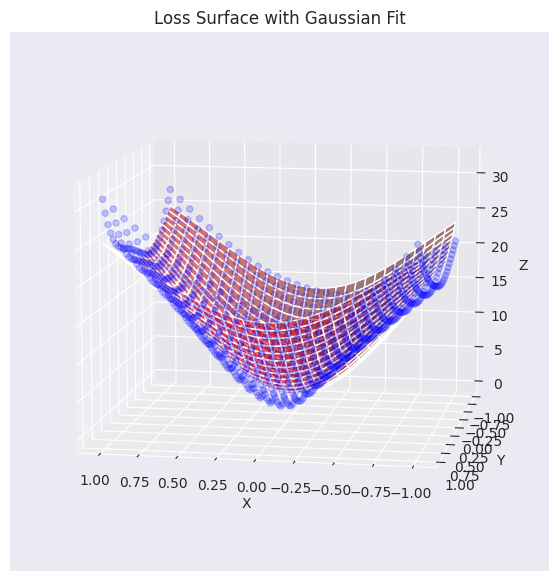

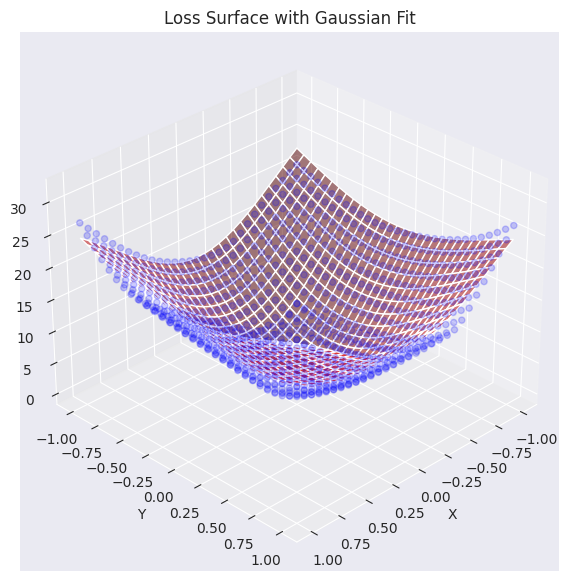

In [ ]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from dldna.chapter_05.visualization.loss_surface import hessian_eigenvectors, xy_perturb_loss, visualize_loss_surface, linear_interpolation
from dldna.chapter_04.utils.data import get_dataset  
from dldna.chapter_04.utils.metrics import load_model  
from dldna.chapter_05.optimizers.basic import SGD, Adam
from dldna.chapter_05.visualization.gaussian_loss_surface import (
    get_opt_params,  visualize_gaussian_fit, train_loss_surface, visualize_optimization_path
)


# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get the dataset
_, test_dataset = get_dataset(dataset="FashionMNIST")
# Create a small dataset
small_dataset = Subset(test_dataset, torch.arange(0, 256))
data_loader = DataLoader(small_dataset, batch_size=256, shuffle=True)
loss_func = nn.CrossEntropyLoss()

trained_model, _ = load_model(model_file="SimpleNetwork-ReLU.pth", path="tmp/models/")
# trained_model, _ = load_model(model_file="SimpleNetwork-Tanh.pth", path="tmp/models/")

trained_model = trained_model.to(device)

# Loss surface data generation
top_n = 2
top_eigenvalues, top_eignevectors = hessian_eigenvectors(
    model=trained_model,
    loss_func=loss_func,
    data_loader=data_loader,
    top_n=top_n,
    is_cuda=True
)

# Define lambda range
d_min, d_max, d_num = -1, 1, 30
lambda1 = np.linspace(d_min, d_max, d_num).astype(np.float32)
lambda2 = np.linspace(d_min, d_max, d_num).astype(np.float32)

# Calculate loss surface
x, y, z = xy_perturb_loss(
    model=trained_model,
    top_eigenvectors=top_eignevectors,
    data_loader=data_loader,
    loss_func=loss_func,
    lambda1=lambda1,
    lambda2=lambda2,
    device=device
)


# After generating loss surface data
popt, _, offset = get_opt_params(x, y, z)

# Visualize Gaussian fitting
visualize_gaussian_fit(x, y, z, popt, offset, d_min, d_max, d_num)

# View from a different angle
visualize_gaussian_fit(x, y, z, popt, offset, d_min, d_max, d_num,
                      elev=30, azim=45)

The actual loss plane data (blue dots) and the approximated plane using a Gaussian function (red) are visualized together. As can be seen from the graph, the generated Gaussian function relatively well captures the *overall trend of the original loss surface data* (especially, the concave shape in the center), creating a similar surface. Now, using this approximated loss plane function, we will analyze and visualize how various optimization algorithms (optimizers) find the minimum value and their paths.

### 5.4.2 Path Visualization

Using the loss surface approximated by a Gaussian function, let's visualize how the optimizer works in a 2D plane.

Please provide the original Korean text for translation. I will translate it into English according to the given instructions.

In [ ]:
# Gaussian fitting
popt, _, offset = get_opt_params(x, y, z)
gaussian_params = (*popt, offset)

# Calculate optimization paths
points_sgd = train_loss_surface(
    lambda params: SGD(params, lr=0.1),
    [d_min, d_max], 100, gaussian_params
)
points_sgd_m = train_loss_surface(
    lambda params: SGD(params, lr=0.05, momentum=0.8),
    [d_min, d_max], 100, gaussian_params
)
points_adam = train_loss_surface(
    lambda params: Adam(params, lr=0.1),
    [d_min, d_max], 100, gaussian_params
)

# Visualization
visualize_optimization_path(
    x, y, z, popt, offset,
    [points_sgd, points_sgd_m, points_adam],
    act_name="ReLU"
)

The graph shows the learning paths of three optimization algorithms, SGD, Momentum SGD, and Adam, on a loss surface approximated by a Gaussian function. The three algorithms show **different** characteristics in both gentle and steep areas.

*   **SGD (orange):** In gentle areas, it approaches the lowest point with a relatively *wide range of oscillations*, but in steep areas, it tends to *oscillate with a larger amplitude* and has a *slower convergence speed* near the lowest point.
*   **Momentum SGD (green):** Compared to SGD, it approaches the lowest point with *less oscillation* and a *smoother curve*. Thanks to the momentum effect, it can find the lowest point relatively *stably* even in steep areas.
*   **Adam (red):** With the *least oscillation*, it responds *sensitively to gradient changes* and reaches the lowest point along an efficient path. *In particular, it shows a relatively fast convergence speed even in steep areas*. This is due to Adam's adaptive learning rate adjustment mechanism.

In practice, Momentum SGD is much more preferred than SGD itself, and adaptive optimization algorithms like Adam or AdamW are also widely used. Generally, the loss surface tends to be flat in most areas but has a narrow and deep valley shape near the minimum value. Therefore, a large learning rate can cause overshooting or divergence, so it is common to use a learning rate scheduler that gradually decreases the learning rate. Additionally, it is essential to consider not only the choice of optimization algorithm but also an appropriate learning rate scheduler, batch size, regularization techniques, and more.

![](../../../assets/images/04_loss_resnet_ft_imagenet_2.png)

![](../../../assets/images/04_loss_resnet_ft_imagenet_1.png)

The above loss surface image is a 3D visualization of the loss surface of a ResNet-50 model newly trained on the ImageNet dataset (using the top two eigenvectors of the Hessian matrix calculated by PyHessian as axes). Unlike the Gaussian function approximation, the actual loss surface of deep learning models has a much more complex and irregular shape. Nevertheless, it can be seen that the large tendency for the minimum value to exist in the central area (blue area) is maintained. This visualization helps provide an intuitive understanding of how complex the actual loss surface of deep learning models is and why optimization is a difficult problem.

## 5.5 Dynamic Analysis of the Optimization Process: Exploring Learning Trajectories

Understanding how optimization algorithms navigate through the loss landscape to find the minimum value in deep learning model training is crucial. *Especially with the emergence of large language models (LLMs), analyzing and controlling the learning dynamics of models with billions of parameters has become even more important.*

### 5.5.1 Characteristics of the Training Process

The deep learning model training process can be divided into initial, mid-term, and late stages, each with its own characteristics.

1.  **Stage-wise Characteristics:**

    *   **Initial:** The gradient norm is large and fluctuates significantly, and the loss function value decreases rapidly.
    *   **Mid-term:** The gradient stabilizes, and parameters explore the optimal region.
    *   **Late:** Parameters fine-tune around local optima. (Early termination is important)

2.  **Layer-wise Gradient Characteristics:**

    *   In deep neural networks, gradients tend to be larger near the input layer and smaller near the output layer. (vanishing gradient problem)
    *   This is due to the chain rule during backpropagation.
    *   Residual connections alleviate this imbalance, helping stabilize learning in deeper layers.

3.  **Parameter Dependencies:**

    *   Neural network parameters are interdependent, making the optimization process nonlinear.
    *   Some parameters may have a greater impact on learning, so balance between parameters is crucial.

4.  **Optimization Path Analysis:**

    *   The path that parameters move along the loss surface during optimization is called the optimization path.
    *   Wide and gentle valley-shaped local minima tend to have better generalization performance than narrow and steep ones.
    *   Saddle points are very common in high-dimensional spaces. (Momentum, Adam, etc., are designed to avoid them)
    *   In flat areas of the loss surface, gradients can become small, slowing down learning. (Adaptive learning rate algorithms help)

### 5.5.2 Learning Stability Analysis and Control

#### Stability Analysis Methodology

To analyze the stability of the optimization process, consider the following:

1.  **Gradient Diagnostics:**

    *   Detect vanishing or exploding gradient phenomena.
    *   Periodically observe the gradient norm during training.

2.  **Hessian-based Analysis:**

    *   The distribution of Hessian matrix eigenvalues and condition numbers indicate optimization path stability.
    *   (Refer to Hessian-based visualization in Section 5.3)

3.  **Real-time Monitoring:**

    *   Monitor the gradient norm, parameter update size, loss function value, and performance metrics in real-time during learning.

##### Stabilization Techniques

*   **Gradient Clipping:** Limit the gradient size (norm) to not exceed a threshold.

    $g \leftarrow \text{clip}(g) = \min(\max(g, -c), c)$
*   $g$: gradient, $c$: threshold
*   **Adaptive Learning Rate:** Adam, RMSProp, Lion, Sophia, etc. automatically adjust the learning rate based on gradient statistics.
*   **Learning Rate Scheduler:** gradually decrease the learning rate based on the training epoch or validation loss.
*   **Hyperparameter Optimization:** automatically search and adjust optimization-related hyperparameters.

##### Latest Research Trends

Recent (2024) studies on learning dynamics are advancing in the following directions:

*   **Predictive Stabilization:** analyze model structure, initialization, and dataset characteristics before training to pre-emptively remove or alleviate instability factors.
*   **Unified Analysis:** deeply understand optimization algorithms by jointly analyzing curvature information (Hessian) and gradient statistics.
*   **Automated Control:** use reinforcement learning, etc. to automatically adjust the hyperparameters of optimization algorithms.

These studies contribute to making deep learning model training more stable and efficient and help to understand the "black box".

Now, let's explore the dynamic analysis of the optimization process through a simple example.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset  # Import Subset
from dldna.chapter_05.visualization.train_dynamics import visualize_training_dynamics
from dldna.chapter_04.utils.data import get_dataset  
from dldna.chapter_04.utils.metrics import load_model  

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the FashionMNIST dataset (both training and testing)
train_dataset, test_dataset = get_dataset(dataset="FashionMNIST")
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
loss_func = nn.CrossEntropyLoss()

# Load a pre-trained model (e.g., ReLU-based network)
trained_model, _ = load_model(model_file="SimpleNetwork-ReLU.pth", path="tmp/models/")
trained_model = trained_model.to(device)

# Choose an optimizer (e.g., Adam)
optimizer = optim.Adam(trained_model.parameters(), lr=0.001)

# Call the training dynamics visualization function (e.g., train for 10 epochs with the entire training dataset)
metrics = visualize_training_dynamics(
    trained_model, optimizer, train_loader, loss_func, num_epochs=20, device=device
)

# Print the final results for each metric
print("Final Loss:", metrics["loss"][-1])
print("Final Grad Norm:", metrics["grad_norm"][-1])
print("Final Param Change:", metrics["param_change"][-1])
print("Final Weight Norm:", metrics["weight_norm"][-1])
print("Final Loss Improvement:", metrics["loss_improvement"][-1])

The example above actually shows various aspects of the learning dynamics described. Using a pre-trained SimpleNetwork-ReLU model on the FashionMNIST dataset and continuing to train it with the Adam optimization algorithm, we visualized the following five key metrics for each epoch:

*   **Loss (loss):** Shows how the loss function value decreases during training. (blue line)
*   **Grad Norm (gradient norm):** Represents the size of the gradient (L2 norm). (red line)
*   **Param Change (parameter change):** Represents the change in parameters (weights) compared to the previous epoch (L2 norm).
*   **Weight Norm (weight norm):** Represents the size of all model parameters (weights) (L2 norm). (purple line)
*   **Loss Improvement (loss improvement):** Represents how much the loss function value has decreased compared to the previous epoch. (yellow line)

The graph shows the following:

*   **Loss:** The loss value, which was around 0.51 in the initial epoch (epoch 1), consistently decreases as training progresses and reaches around 0.16 in the final epoch (epoch 20).
*   **Grad Norm:** The gradient norm, which was relatively high in the initial epoch (around 4.5), gradually decreases as training progresses and reaches around 2.0 in the final epoch.
*   **Param Change:** The parameter change is large at the beginning of training but tends to decrease as training progresses. This means that the model's parameters change less as it gets closer to the optimal point.
*   **Weight Norm:** The weight norm consistently increases throughout the training process. This means that the model's parameters become "larger" through training. (However, this does not necessarily mean overfitting.)
*   **Loss Improvement:** The loss improvement is large at the beginning of training and tends to decrease as training progresses.

Through this example, we can visually confirm the process of the optimization algorithm minimizing the loss function, the change in gradients, and the change in parameters, and gain an intuitive understanding of the learning dynamics.

### Conclusion

In this chapter 5, we deeply explored various topics related to optimization, a key element of deep learning model training. We understood the importance of weight initialization methods, the principles and characteristics of various optimization algorithms (SGD, Momentum, Adam, Lion, Sophia, AdaFactor), and loss surface visualization and learning dynamics analysis to better understand the training process of deep learning models.

In chapter 6, we will learn about regularization, a key technique for improving the generalization performance of deep learning models. We will examine the principles and effects of various regularization techniques such as L1/L2 regularization, dropout, batch normalization, and data augmentation, and learn how to apply them through practical examples.

### Practice Problems

#### Basic Problems

1.  **SGD Manual Calculation:** Manually calculate the SGD update rule for more than three steps with a learning rate of 0.1 and momentum of 0.9 on the loss function $L(w) = w^2$. The initial weight is set to $w_0 = 2$.
2.  **Gradient Descent Convergence Speed Comparison:** Apply gradient descent to a simple two-dimensional function $f(x, y) = x^2 + 2y^2$, and compare the convergence speeds by changing the learning rate to 0.1, 0.01, and 0.001.
3.  **Initialization Method Comparison:** Compare Kaiming initialization and Xavier initialization, and explain why Kaiming initialization is more suitable when used with the ReLU activation function.

#### Applied Problems

1.  **Adam Optimizer:** Explain the working principle of the Adam optimizer (including formulas) and describe the roles of the $\beta_1$ and $\beta_2$ parameters.
2.  **Batch Normalization and Initialization:** Explain how batch normalization reduces the importance of initialization methods, and provide reasons for this phenomenon.
3.  **Gaussian Loss Surface:** In an example that approximates a loss surface using Gaussian functions (Section 5.5.1), explain the effect of the parameters of the Gaussian function (amplitude, center point, variance) on the optimization process, and observe how changing each parameter affects the optimization path.

#### Advanced Problems

1.  **Lion Optimizer Analysis:** Explain the core idea of the Lion optimizer (including formulas) and analyze its advantages and disadvantages compared to Adam.
2.  **Initialization Method Experimentation:** For a given dataset (e.g., FashionMNIST) and model (SimpleNetwork in Section 5.1), apply different initialization methods (LeCun, Xavier, Kaiming, Orthogonal) and compare the results (error rate, convergence speed, average condition number, spectral norm, effective rank ratio).
3.  **Optimization Path Visualization:** Refer to the optimization path visualization code in Section 5.5, define your own loss function (e.g., multi-modal function, non-convex function), and visualize and compare the optimization paths of various optimizers (SGD, Momentum, Adam, Lion, etc.). Compare at least three optimizers.

::: {.callout-note collapse="true" title="Click to view contents (Phase-based loss surface analysis)"}
### Practice Problem Solutions

#### Basic Problems

1.  **SGD Manual Calculation:**

    *   **Step 1:**
        *   $g_0 = \frac{dL}{dw}(w_0) = 2w_0 = 4$
        *   $v_0 = 0$ (initial momentum)
        *   $w_1 = w_0 - \eta v_1 = 2 - 0.1 \cdot (0.9 \cdot 0 + 4) = 1.6$
    *   **Step 2:**
        *   $g_1 = 2w_1 = 3.2$
        *   $v_1 = 0.9 \cdot v_0 + g_0= 0.9 \cdot 0 + 4 = 4$
        *   $w_2 = w_1 - \eta \cdot (0.9 \cdot v_1 + g_1) = 1.6 - 0.1 \cdot (0.9 \cdot 4+ 3.2) = 0.92$
    *   **Step 3:**
        *   $g_2 = 2w_2 = 1.84$
        *   $v_2 = 0.9 \cdot 4 + 3.2 = 6.8$
        *   $w_3 = w_2 - \eta \cdot (0.9 * v_2 + g_2) = 0.92 - 0.1 \cdot (0.9 \cdot 6.8 + 1.84) = 0.124$

2.  **Gradient Descent Convergence Speed Comparison:**

    *   The larger the learning rate (0.1), the faster the initial convergence, but it may oscillate near the optimal point.
    *   The smaller the learning rate (0.001), the slower the convergence speed, but it approaches the optimal point more stably.
    *   An appropriate learning rate (0.01) shows a moderate convergence speed and stability.

3.  **Initialization Method Comparison:**

    *   **Kaiming Initialization:** Initializes weights with a distribution having a standard deviation of $\sqrt{2/n_{in}}$, considering the characteristics of ReLU activation functions (making negative inputs 0).
    *   **Xavier Initialization:** Uses a standard deviation of $\sqrt{2/(n_{in} + n_{out})}$, which maintains the variance of inputs and outputs regardless of the type of activation function.
    *   **ReLU + Kaiming:** Since ReLU has linear activation in the positive region, Kaiming initialization provides a larger variance, alleviating the "dead neuron" problem and helping with faster learning.

#### Application Problems

1.  **Adam Optimizer:**

    *   **Working Principle:** Adam is an optimizer that combines the ideas of Momentum and RMSProp.
        *   **Momentum:** Gives inertia by using the exponential weighted average of past gradients (first moment, $m_t$).
        *   **RMSProp:** Adjusts the learning rate for each parameter by using the exponential weighted average of squared past gradients (second moment, $v_t$).
        *   **Bias Correction:** Corrects for the bias in $m_t$ and $v_t$ that occurs during initial stages.
    *   **Formula:**
        *   $m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t$
        *   $v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2$
        *   $\hat{m_t} = m_t / (1 - \beta_1^t)$
        *   $\hat{v_t} = v_t / (1 - \beta_2^t)$
        *   $w_{t+1} = w_t - \eta \hat{m_t} / (\sqrt{\hat{v_t}} + \epsilon)$
    *   **Role of $\beta_1$, $\beta_2$:**
        *   $\beta_1$: Controls the exponential decay rate for the first moment (momentum). (Typically 0.9)
        *   $\beta_2$: Controls the exponential decay rate for the second moment (RMSProp). (Typically 0.999)

2.  **Batch Normalization and Initialization:**

    *   Batch normalization normalizes the input of each layer, which can improve the stability and speed of training.
    *   Initialization methods like Kaiming and Xavier are designed to work well with batch normalization by initializing weights in a way that maintains the variance of inputs as they flow through the network.
*   **Batch Normalization:** normalizes the input of each mini-batch to have a mean of 0 and a variance of 1.
*   **Reducing the Impact of Initialization:** batch normalization reduces the internal covariate shift in the network, lowering the dependence on the initial weight distribution.
*   **Reason:** normalized inputs place the activation functions in an appropriate range (e.g., the positive region of ReLU), mitigating the vanishing/exploding gradient problem and stabilizing learning.

3.  **Gaussian Loss Surface:**
    *   **Amplitude (A):** adjusts the overall size of the loss function; a large amplitude can make learning unstable due to large variations in loss values.
    *   **Center ($x_0$, $y_0$):** determines the location of the minimum value of the loss function, which the optimization algorithm moves towards.
    *   **Variance ($\sigma_1$, $\sigma_2$):** represents the degree of change of the loss function in each axis direction; small variance results in a narrow and pointed shape, while large variance gives a broad and gentle shape. Different variances require adjusting the learning speed differently for each direction.

#### Advanced Problems

1.  **Lion Optimizer Analysis:**

    *   **Core Idea:** performs updates using only the sign of the gradient.
    *   **Formula:**
        ```
        c_t = β_1 * m_{t-1} + (1 - β_1) * g_t
        w_{t+1} = w_t - η * sign(c_t)
        m_t = c_t
        ```
        * only uses the sign of updates, so it doesn't need to calculate and store the 2nd moment like Adam
    *   **Advantages:**
        *   uses less memory than Adam (doesn't store 2nd moments)
        *   update size is uniform for all parameters, making it robust to sparse gradients
    *   **Disadvantages:**
        *   ignores gradient magnitude information, potentially leading to slower convergence than Adam in certain situations
        *   may be more sensitive to learning rate tuning than Adam

2.  **Initialization Method Experiment:**

    *   **Experiment Design:**
        *   uses the same model (SimpleNetwork) and dataset (FashionMNIST)
        *   applies LeCun, Xavier, Kaiming, and Orthogonal initializations
        *   uses the same optimization algorithm (e.g., Adam) and learning rate
        *   trains for a sufficient number of epochs (e.g., 20) and records evaluation metrics (error rate, convergence speed, average condition number, spectral norm, effective rank) at each epoch
    *   **Result Analysis:**
        *   when using ReLU activation functions, Kaiming initialization is likely to perform best
        *   Orthogonal initialization may perform well in RNN/LSTM models
        *   Xavier initialization may perform well with tanh and sigmoid activation functions
        *   LeCun initialization may perform poorly in modern networks

3.  **Optimization Path Visualization:**
*   **Defining one's own loss function:**
*   Example: $f(x, y) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2$ (Himmelblau function, multi-modal function)
*   Example: $f(x, y) = 0.5x^2 - 0.25y^2 + 3$ (non-convex function with a saddle point)
*   **Choosing an optimization algorithm:** SGD, Momentum(SGD with momentum), Adam, Lion
*   **Visualization:** Refer to the code in Section 5.5 to visualize the optimization path of each optimizer on a 2D plane.
*   **Result analysis:**
    *   SGD is likely to fall into local minima/saddle points.
    *   Momentum can escape local minima through inertia, but may oscillate.
    *   Adam can reach the optimal point more efficiently thanks to its adaptive learning rate.
    *   Lion may show similar or faster convergence to Adam, but can be sensitive to learning rate tuning.
    *   Compare and analyze optimization results based on the shape of the loss function, such as multi-modality and saddle points.
:::

### Reference Materials
1.  **[An overview of gradient descent optimization algorithms](https://arxiv.org/abs/1609.04747)** (Sebastian Ruder, 2016) - An excellent overview paper on deep learning optimization algorithms. It compares and analyzes various algorithms such as SGD, Momentum, AdaGrad, RMSProp, and Adam.
2.  **[Visualizing the Loss Landscape of Neural Nets](https://arxiv.org/abs/1712.09913)** (Li et al., 2018) - A pioneering paper on loss surface visualization. It shows how residual connections can flatten the loss surface.
3.  **[Optimization for Deep Learning Highlights in 2023](https://www.google.com/search?q=https://ruder.io/deep-learning-optimization-2023/)** (Sebastian Ruder, 2023) - A blog post summarizing the key points of deep learning optimization in 2023. It is useful for understanding the latest research trends.
4.  **[Improving Deep Learning with Better Initialization](https://arxiv.org/abs/2110.08536)** (Mishkin & Matas, 2021) - A paper on modern research trends in initialization. It compares various initialization methods and provides practical guidelines.
5.  **[Symbolic Discovery of Optimization Algorithms](https://www.google.com/url?sa=E&source=gmail&q=https://arxiv.org/abs/2302.06675)** (Chen et al. 2023) - A paper on the Lion algorithm discovered by Google Brain.
6.  **[PyHessian: Neural Networks Through the Lens of the Hessian](https://arxiv.org/abs/1912.07145)** (Yao et al., 2020) - A paper on PyHessian, a tool for analyzing loss surfaces using Hessian matrices.
7.  **[The Marginal Value of Adaptive Gradient Methods in Machine Learning](https://arxiv.org/abs/1705.08292)** (Wilson et al., 2017) - A paper showing that adaptive learning rate methods (such as Adam) are not always better than SGD.
8.  **[How to escape saddle points efficiently](https://www.offconvex.org/2016/03/22/saddlepoints/)** (Ge et al., 2015) - A blog post explaining how to efficiently escape saddle points using perturbed gradient descent.
9.  **[Deep Understanding of Modern Initialization Methods with Block Diagonal Matrices](https://www.google.com/search?q=https://openreview.net/forum%3Fid%3DFpgg9h-xO_a)** (Huang et al., 2021) - A paper analyzing initialization methods using block diagonal matrices.
10. **[AdaHessian: An Adaptive Second Order Optimizer for Machine Learning](https://www.google.com/search?q=https://proceedings.neurips.cc/paper/2020/hash/9c838d2e45b2ad1094d42f4ef36764f6-Abstract.html)** (Yao et al., 2020) - A paper on AdaHessian, an optimizer that uses the diagonal elements of Hessian matrices to leverage second-order information.
11. **[A Closer Look at Smoothness in Deep Learning: A Tensor Decomposition Approach](https://arxiv.org/abs/2502.00894)** (Defazio & Bottou, 2025) - A paper analyzing the smoothness of deep learning models using tensor decomposition.
12. **[Understanding Measures of Efficiency for Stochastic Optimization](https://arxiv.org/abs/2502.00894)** (Defazio & Bottou, 2025) - A paper proposing methods to measure the efficiency of stochastic optimization algorithms.
13. **[Deep Learning](https://www.google.com/url?sa=E&source=gmail&q=https://www.deeplearningbook.org/)** (Goodfellow, Bengio, Courville, 2016) - A deep learning textbook that covers initialization and optimization in chapters 6 (Deep Feedforward Networks) and 8 (Optimization for Training Deep Models).
14. **[Stanford CS231n: Convolutional Neural Networks for Visual Recognition](https://www.google.com/url?sa=E&source=gmail&q=https://cs231n.github.io/optimization-1/)** - A Stanford University deep learning course that covers optimization in the Optimization section.
15. **[Papers with Code - Optimization Methods](https://www.google.com/search?q=https://paperswithcode.com/methods/category/optimization-methods)** - A website that collects recent papers on optimization methods.
1. **[An overview of gradient descent optimization algorithms](https://arxiv.org/abs/1609.04747)** (Sebastian Ruder, 2016) - This is an excellent overview paper on deep learning optimization algorithms. It compares and analyzes various algorithms such as SGD, Momentum, AdaGrad, RMSProp, and Adam.
2. **[Visualizing the Loss Landscape of Neural Nets](https://arxiv.org/abs/1712.09913)** (Li et al., 2018) - This is a pioneering paper on visualizing loss surfaces. It shows how residual connections flatten the loss surface.
3. **[Optimization for Deep Learning Highlights in 2023](https://www.google.com/search?q=https://ruder.io/deep-learning-optimization-2023/)** (Sebastian Ruder, 2023) - This is a blog post summarizing the main points of deep learning optimization in 2023. It is useful for understanding the latest research trends.
4. **[Improving Deep Learning with Better Initialization](https://arxiv.org/abs/2110.08536)** (Mishkin & Matas, 2021) - This paper presents modern research trends on initialization. It compares various initialization methods and provides practical guidelines.
5. **[Symbolic Discovery of Optimization Algorithms](https://www.google.com/url?sa=E&source=gmail&q=https://arxiv.org/abs/2302.06675)** (Chen et al. 2023) - This paper is about the Lion algorithm discovered by Google Brain.
6. **[PyHessian: Neural Networks Through the Lens of the Hessian](https://arxiv.org/abs/1912.07145)** (Yao et al., 2020) - This paper is about PyHessian, a tool for analyzing loss surfaces using the Hessian matrix.
7. **[The Marginal Value of Adaptive Gradient Methods in Machine Learning](https://arxiv.org/abs/1705.08292)** (Wilson et al., 2017) - This paper shows that adaptive learning rate methods (such as Adam) are not always better than SGD.
8. **[How to escape saddle points efficiently](https://www.offconvex.org/2016/03/22/saddlepoints/)** (Ge et al., 2015) - This blog post explains how to efficiently escape saddle points using perturbed gradient descent.
9. **[Deep Understanding of Modern Initialization Methods with Block Diagonal Matrices](https://www.google.com/search?q=https://openreview.net/forum%3Fid%3DFpgg9h-xO_a)** (Huang et al., 2021) - This paper analyzes initialization methods using block diagonal matrices.
10.
**[AdaHessian: An Adaptive Second Order Optimizer for Machine Learning](https://www.google.com/search?q=https://proceedings.neurips.cc/paper/2020/hash/9c838d2e45b2ad1094d42f4ef36764f6-Abstract.html)** (Yao et al., 2020) - a paper on the AdaHessian optimizer that uses the diagonal elements of the Hessian matrix to utilize second-order information. 
11. **[A Closer Look at Smoothness in Deep Learning: A Tensor Decomposition Approach](https://arxiv.org/abs/2411.01593)** (Li et al., 2024) - a paper analyzing the smoothness of deep learning models using tensor decomposition.
12. **[Understanding Measures of Efficiency for Stochastic Optimization](https://arxiv.org/abs/2502.00894)** (Defazio & Bottou, 2025) - a paper proposing methods to measure the efficiency of stochastic optimization algorithms.
13. **[Deep Learning](https://www.google.com/url?sa=E&source=gmail&q=https://www.deeplearningbook.org/)** (Goodfellow, Bengio, Courville, 2016) - a deep learning textbook that covers initialization and optimization-related content in chapters 6 (Deep Feedforward Networks) and 8 (Optimization for Training Deep Models).
14. **[Stanford CS231n: Convolutional Neural Networks for Visual Recognition](https://www.google.com/url?sa=E&source=gmail&q=https://cs231n.github.io/optimization-1/)** - a Stanford University deep learning course that covers optimization-related content in the Optimization part.
15. **[Papers with Code - Optimization Methods](https://www.google.com/search?q=https://paperswithcode.com/methods/category/optimization-methods)** - a website collecting recent papers on optimization methods.